In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import scienceplots

plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import (
    savefig,
    FKFit,
    FitInput,
    FitResult,
    perform_fit,
    perform_fit_rounds,
    FK_fit,
    num_err_to_latex_str,
)
from scipy.stats import chi2
from dataclasses import dataclass

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
# "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat"

# DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME, "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat")
# data = read_mat(DATAPATH)["Data"]
DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME)

fnames = os.listdir(DATAPATH)
fnames = [os.path.join(DATAPATH, fname) for fname in fnames]
data_dict = {}

for fname in fnames:
    data = read_mat(fname)["Data"]
    resistance = int(data["Resistance"])
    if (
        Path(fname).stem
        == "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V"
    ):
        data = {
            "counts": data["MeasureCounts"][:, :-6:5],
            "current": data["MeasureCurrent"][:, :-6:5] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    else:
        voltagelist = data["VoltageList"]
        powerlist = data["PowerList"] * 1e6
        data = {
            "counts": data["MeasureCounts"],
            "current": data["MeasureCurrent"] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    data_dict[resistance] = data

resistances = sorted(list(data_dict.keys()))

/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


In [ ]:
def plot_2d_maps(data_dict, powerlist, voltagelist, resistances):
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, (ax, ax1) = plt.subplots(1, 2, figsize=(11, 4))
        pcm = ax.contourf(
            voltagelist,
            powerlist,
            data_dict[resistance]["counts"],
            levels=len(voltagelist),
        )
        cb = fig.colorbar(pcm, ax=ax, pad=0.01)
        cb.set_label(r"Counts", fontsize=14)
        ax.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax.set_ylabel(r"Power [$\mu W$]", fontsize=14)

        pcm = ax1.contourf(
            voltagelist,
            powerlist,
            np.abs(data_dict[resistance]["current"]),
            levels=len(voltagelist),
        )
        cb = fig.colorbar(pcm, ax=ax1, pad=0.01)
        cb.set_label(r"Current [$\mu W$]", fontsize=14)
        ax1.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax1.set_ylabel(r"Power [$\mu W$]", fontsize=14)
        plt.show()

DATA FOR RESISTANCE: 0


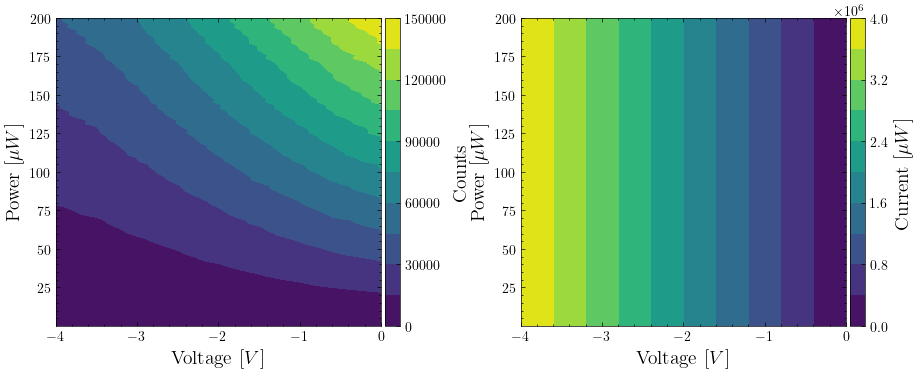

DATA FOR RESISTANCE: 97,500


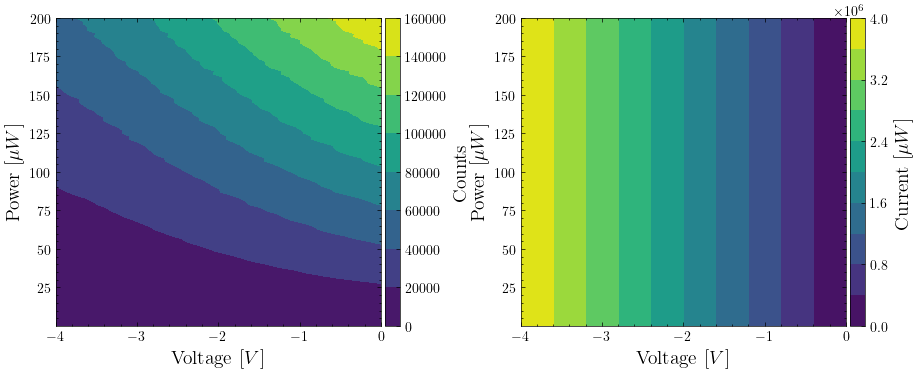

DATA FOR RESISTANCE: 325,300


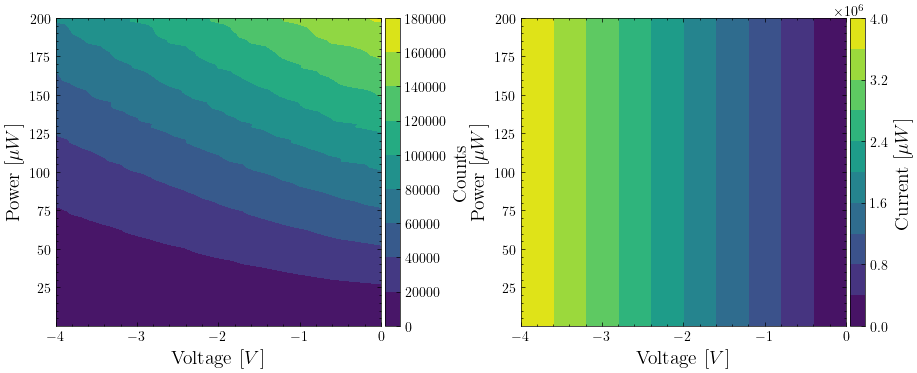

DATA FOR RESISTANCE: 552,000


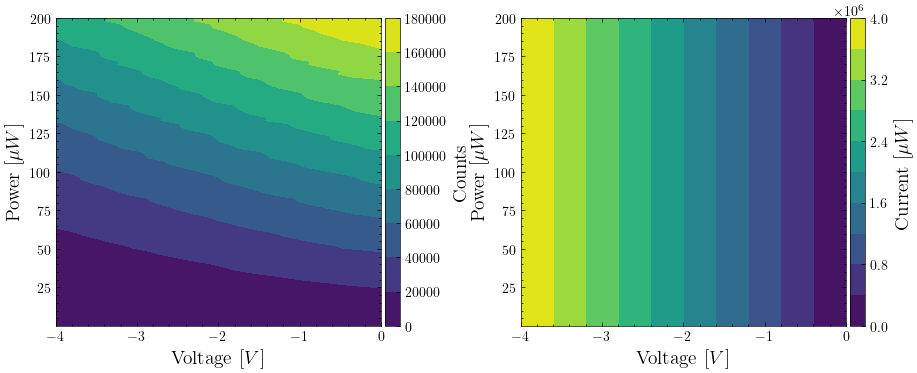

DATA FOR RESISTANCE: 677,000


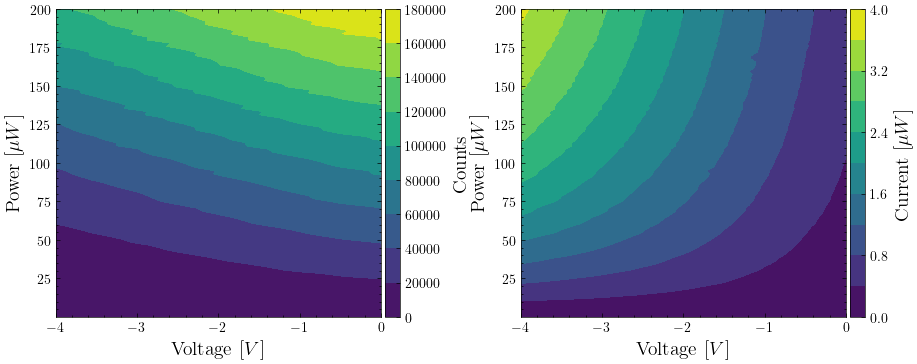

DATA FOR RESISTANCE: 807,000


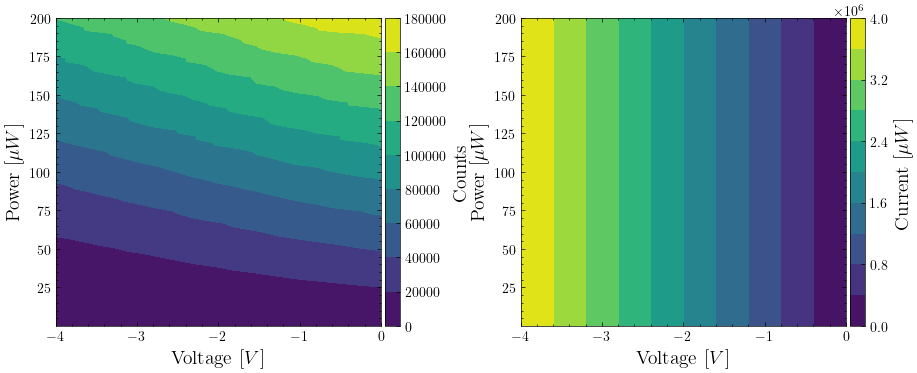

DATA FOR RESISTANCE: 1,000,000


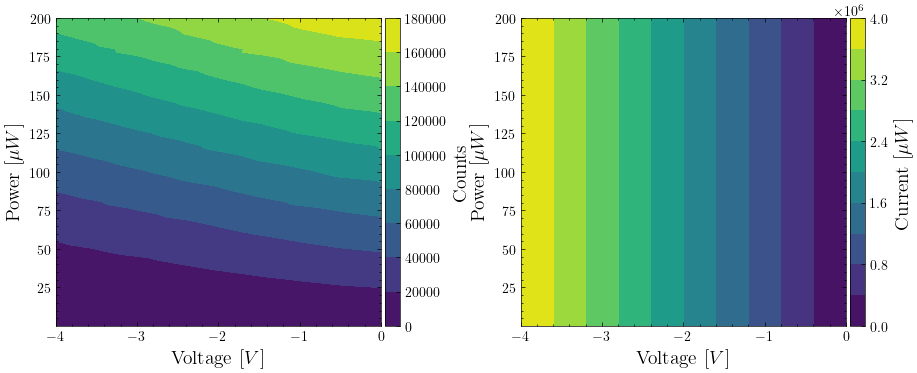

DATA FOR RESISTANCE: 3,012,000


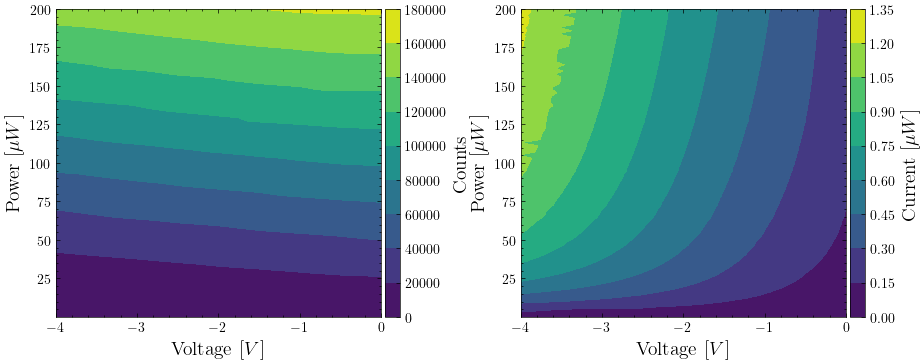

DATA FOR RESISTANCE: 10,000,000


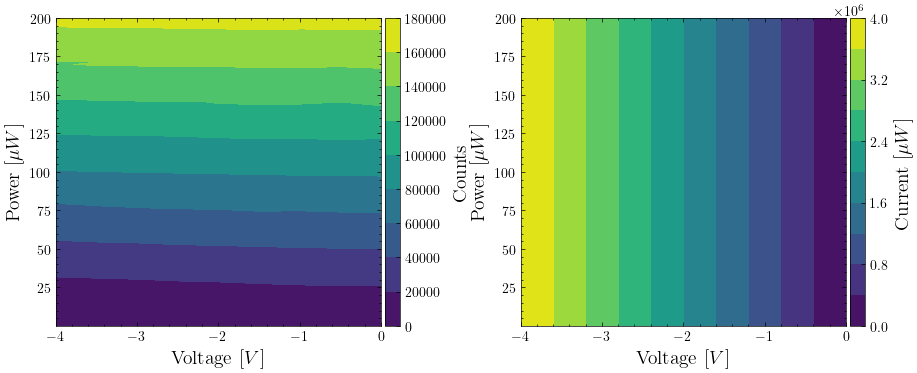

In [5]:
plot_2d_maps(data_dict, powerlist, voltagelist, resistances)

In [ ]:
power_num = 50


def linear2(V_d: np.ndarray, T_0: float, g: float):
    alpha = FK_fit(2.99792458e5 / 321.5, 0, 298, V_d)
    return T_0 * np.exp(-g * alpha)


lin2_fit_result = perform_fit(
    FitInput(
        voltagelist,
        data_dict[0]["counts"][power_num],
        np.sqrt(data_dict[0]["counts"][power_num]),
        linear2,
        [14000, 1.2e-3],
    )
)
voltage_lin = np.linspace(0, -4, 1000)

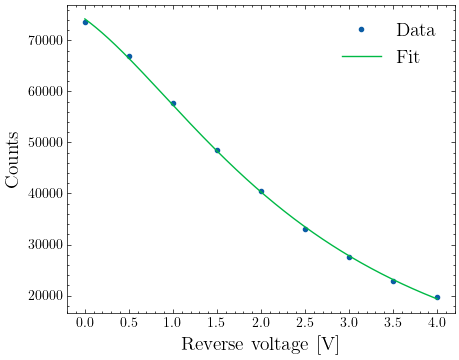

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.abs(voltagelist), data_dict[0]["counts"][power_num], ".", label="Data")
ax.plot(
    np.abs(voltage_lin), linear2(voltage_lin, *lin2_fit_result.parameters), label="Fit"
)
ax.set_xlabel(r"Reverse voltage [V]", fontsize=14)
ax.set_ylabel(r"Counts", fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.legend(fontsize=14)
# savefig(NB_NAME, "voltage_counts_fit_100muW", fig)
plt.show()

In [8]:
print(f"g=Gamma*L calculations:\n{lin2_fit_result.parameters[1]}")

g=Gamma*L calculations:
0.0015566610020618394


In [9]:
gamma_lin2 = lin2_fit_result.parameters[1] / 3.5e-3
print(f"Gamma calculations:\n{gamma_lin2}")

Gamma calculations:
0.44476028630338266


In [ ]:
gamma_vals = []
T_0_vals = []
b_vals = []

for power_idx in range(1, len(data_dict[0]["counts"])):
    fit_result_pow = perform_fit(
        FitInput(
            voltagelist,
            data_dict[0]["counts"][power_idx],
            10 * np.sqrt(data_dict[0]["counts"][power_idx]),
            linear2,
            [14000, 1.2e-3],
        )
    )
    if not (fit_result_pow.success):
        print(f"Fit at index {power_idx} was not completely successful!")
    gamma_vals.append(fit_result_pow.parameters[1] / 3.5e-3)
    T_0_vals.append(fit_result_pow.parameters[0])


gamma_vals = np.array(gamma_vals)

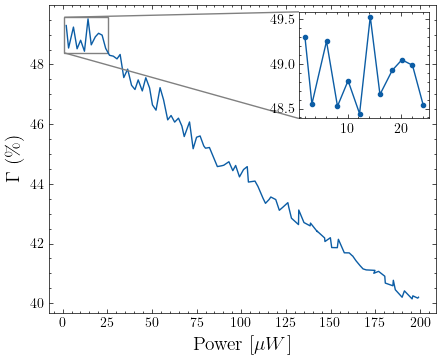

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(data_dict[0]["M_power"][1:], 100 * gamma_vals)
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"$\Gamma \ (\%)$", fontsize=14)
axins = zoomed_inset_axes(ax, zoom=3, loc=1)
axins.plot(data_dict[0]["M_power"][1:][0:12], 100 * gamma_vals[0:12], ".-")
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
# savefig(NB_NAME, "gamma_pow", fig)
plt.show()

In [12]:
print(f"Gamma in %:\n{np.mean(100 * gamma_vals):.0f}%±{np.std(100 * gamma_vals):.0f}%")
print(
    f"Gamma in % (assuming good coupling):\n{np.mean(100 * gamma_vals[0:12]):.1f}%±{100 * np.std(gamma_vals[0:12]) / np.sqrt(12):.1f}%"
)

Gamma in %:
44%±3%
Gamma in % (assuming good coupling):
48.9%±0.1%


In [ ]:
@dataclass
class NLResult:
    coeff: float
    coeff_pow: float
    deriv2: np.ndarray


def calculate_nl_coeff(fit_input: FitInput, fit_result: FitResult) -> np.ndarray:
    linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
    y_fit = fit_input.fit_func(linspace, *fit_result.parameters)
    deriv = np.gradient(y_fit, linspace, edge_order=2)
    deriv2 = np.gradient(deriv, linspace, edge_order=2)
    nl_coeff_idx = np.argmax(deriv2)
    if nl_coeff_idx == 0:
        nl_coeff = 0
    else:
        nl_coeff = deriv2[nl_coeff_idx]
    return NLResult(nl_coeff, linspace[nl_coeff_idx], deriv2)


def pv_power_counts_fit(
    data_dict: dict,
    resistance: int,
    voltages: np.ndarray,
    initial_guesses: list[float],
    softloss: bool = False,
    initial_guesses_feedback: bool = False,
    bounds: dict[str, tuple[float, float]] | None = None,
) -> FitResult:
    counts = data_dict[resistance]["counts"]
    power = data_dict[resistance]["M_power"]
    error = counts * 0.02

    fit_inputs = []
    fit_results = []
    nl_results = []
    # nl_coeffs = []
    # nl_idc = []
    # nl_derivs2 = []

    L = 3.5e-3  # Waveguide length in cm
    wl = 2.99792458e5 / 321.5  # Frequency in Thz to wavelength in nm
    T = 298  # Temperature in Kelvin

    for idx, voltage in enumerate(voltages):
        # for idx in range(len(voltages) - 1, -1, -1):
        # voltage = voltages[idx]
        if int(resistance) == 0:
            resistance = 20_000
        fk_fit = FKFit(power, resistance * 1e-6, L, wl, 0.3, T, voltage)

        # if int(resistance) == 0:
        #     fit_func = fk_fit.FK_fit_power_scaled_no_resist
        #     initial_guesses = [initial_guesses[-1]]
        #     bounds = {"norm": bounds["norm"]}
        # else:
        #     fit_func = fk_fit.FK_fit_power_scaled

        fit_func = fk_fit.FK_fit_power_scaled

        if (not initial_guesses_feedback) or (idx == 0):
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                initial_guesses,
            )
        else:
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                fit_result.parameters,
            )

        fit_result = perform_fit_rounds(
            fit_input, opt_rounds=10, softloss=softloss, bounds=bounds
        )
        nl_result = calculate_nl_coeff(fit_input, fit_result)

        fit_inputs.append(fit_input)
        fit_results.append(fit_result)
        nl_results.append(nl_result)

        print(fit_result.parameters)

        if not fit_result.success:
            print(
                f"Fit with resistance {resistance} and voltage {voltage} was not completely successful."
            )
    return fit_inputs, fit_results, nl_results
    # return fit_inputs[::-1], fit_results[::-1], nl_results[::-1]

In [ ]:
def plot_power_counts_with_fit(inputs, results, voltagelist):

    fig, axs = plt.subplots(3, 3, figsize=(25, 20))

    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(rf"{voltagelist[idx]:.1f} $V$", fontsize=15)
        ax.plot(inputs[idx].xdata, inputs[idx].ydata, ".", label=f"Data")
        linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
        ax.plot(
            linspace,
            inputs[idx].fit_func(linspace, *results[idx].parameters),
            label=f"Fit",
            lw=2,
        )
        ax.legend(frameon=False, fontsize=13)

    fig.text(0.5, 0.06, r"Power [$\mu W$]", ha="center", fontsize=30)
    fig.text(0.09, 0.5, "Counts", va="center", rotation="vertical", fontsize=30)
    plt.show()


def fit_and_plot_for_resistance(
    data_dict: dict,
    voltagelist: np.ndarray,
    resistance: float,
    initial_guesses: list[float],
    softloss=False,
    initial_guesses_feedback=False,
    bounds: dict[str, tuple[float, float]] | None = None,
):
    print(f"PLOTS FOR RESISTANCE {resistance:,}")
    fit_inputs, fit_results, nl_results = pv_power_counts_fit(
        data_dict,
        resistance,
        voltagelist,
        initial_guesses,
        softloss=softloss,
        initial_guesses_feedback=initial_guesses_feedback,
        bounds=bounds,
    )

    plot_power_counts_with_fit(fit_inputs, fit_results, voltagelist)

    max_derivs = []
    max_nl_power = []

    plt.figure(figsize=(7, 5))
    for idx in range(len(fit_inputs)):
        nl_result = nl_results[idx]
        linspace = np.linspace(powerlist[0], powerlist[-1], 1000)
        max_derivs.append(nl_result.coeff)
        max_nl_power.append(nl_result.coeff_pow)
        plt.plot(linspace, nl_result.deriv2, label=f"{voltagelist[idx]}V")
    plt.xlabel(r"Power [$\mu$W]", fontsize=17)
    plt.ylabel(r"Second derivative of counts", fontsize=17)
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(np.abs(voltagelist), max_derivs, ".-")
    ax1.set_xlabel("Reverse bias voltage", fontsize=14)
    ax1.set_ylabel("Non-linearity coefficient", fontsize=14)
    ax2.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
    ax2.set_ylabel("Power at peak non-linearity [$\mu W$]", fontsize=14)
    ax2.plot(np.abs(voltagelist), max_nl_power, ".-")
    plt.show()

    return np.max(max_derivs), voltagelist[np.argmax(max_derivs)]

In [7]:
fit_results_current = []

for idx in range(len(voltagelist)):
    fk_fit_current = FKFit(
        data_dict[677000]["M_power"],
        677000 * 1e-6,
        3.5e-3,
        2.99792458e5 / 321.5,
        0,
        298,
        voltagelist[idx],
    )
    fit_input_current = FitInput(
        data_dict[677000]["M_power"],
        -data_dict[677000]["current"][:, idx],
        np.array([0.1] * len(data_dict[677000]["M_power"])),
        fk_fit_current.FK_fit_current_array,
        [0.05, 0.44, 30],
        # [0.09703086340990627, 0.06475845487640866, 0.7111161023139522],
    )
    fit_result_current = perform_fit(
        fit_input_current, bounds={"eta": [0, 1], "gamma": [0, 2], "alpha_0": [0, 500]}
    )
    fit_results_current.append(fit_result_current)
    print(fit_result_current.parameters)

    if not fit_result_current.success:
        print(f"Fit with voltage {voltagelist[idx]} was not completely successful")

    plt.plot(data_dict[677000]["M_power"], -data_dict[677000]["current"][:, idx], ".")
    plt.plot(
        data_dict[677000]["M_power"],
        fit_input_current.fit_func(
            data_dict[677000]["M_power"], *fit_result_current.parameters
        ),
    )
    plt.show()

KeyboardInterrupt: 

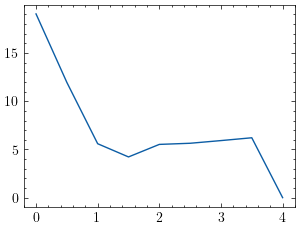

In [16]:
plt.plot(-voltagelist, [res.parameters[-1] for res in fit_results_current])

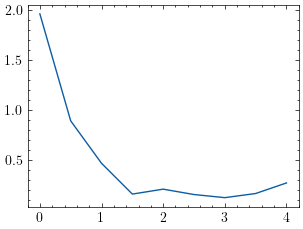

In [17]:
plt.plot(-voltagelist, [res.parameters[-2] for res in fit_results_current])

In [ ]:
alpha_0s = np.array([res.parameters[-1] for res in fit_results_current])
gammas = np.array([res.parameters[-2] for res in fit_results_current])
etas = np.array([res.parameters[-3] for res in fit_results_current])
wl = 2.99792458e5 / 321.5
fk_fit_current = FKFit(
    data_dict[677000]["M_power"],
    677000 * 1e-6,
    3.5e-3,
    2.99792458e5 / 321.5,
    0,
    298,
    voltagelist[idx],
)
exponentials = []
for idx in range(len(etas)):
    eta = etas[idx]
    power = data_dict[677000]["M_power"]
    gamma = gammas[idx]
    alpha_0 = alpha_0s[idx]
    lam = wl

    current = fk_fit_current.FK_fit_current_array(
        data_dict[677000]["M_power"], etas[idx], gammas[idx], alpha_0s[idx]
    )
    exponential = 1 - current / (power * eta / 1.24 * (lam / 1000))
    exponentials.append(exponential)

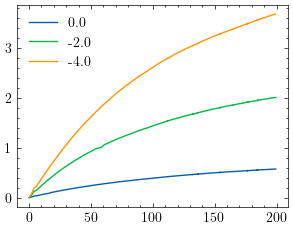

In [ ]:
plt.plot(
    data_dict[677000]["M_power"],
    -data_dict[677000]["current"][:, 0],
    label=f"{voltagelist[0]}",
)
plt.plot(
    data_dict[677000]["M_power"],
    -data_dict[677000]["current"][:, 4],
    label=f"{voltagelist[4]}",
)
plt.plot(
    data_dict[677000]["M_power"],
    -data_dict[677000]["current"][:, -1],
    label=f"{voltagelist[-1]}",
)
plt.legend()

0.0


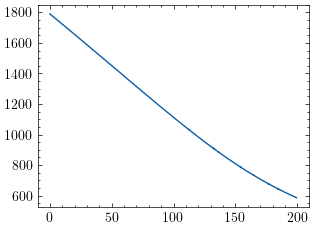

-0.5


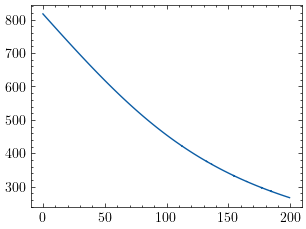

-1.0


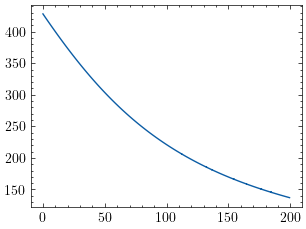

-1.5


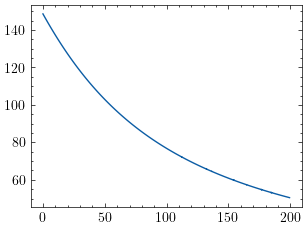

-2.0


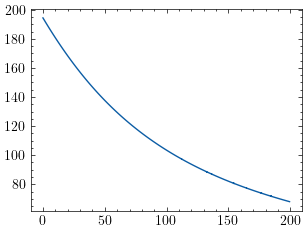

-2.5


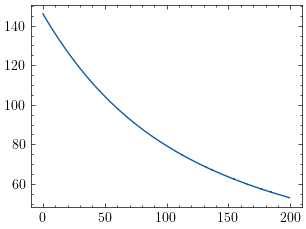

-3.0


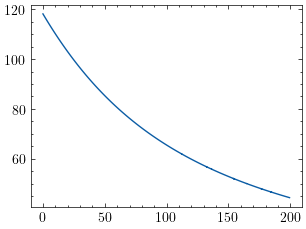

-3.5


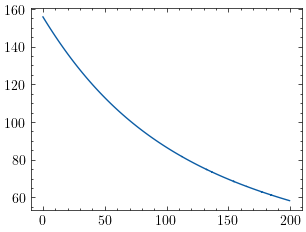

-4.0


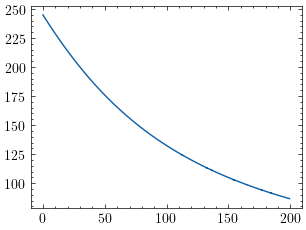

In [31]:
exponentials_zeros = []
for idx, voltage in enumerate(voltagelist):
    print(voltage)
    plt.plot(data_dict[677000]["M_power"], np.log(exponentials[idx]) / (-3.5e-3))
    exponentials_zeros.append((np.log(exponentials) / (-3.5e-3))[idx][0])
    plt.show()

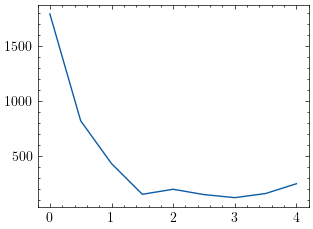

In [32]:
plt.plot(-voltagelist, exponentials_zeros)

In [13]:
max_deriv_res = []
max_nl_voltage_res = []

PLOTS FOR RESISTANCE 0
[0.9999999999999986, 817.0490602280175]
[0.7026089378403283, 804.6399220413642]
[0.3980758991834638, 809.5769831976979]
[0.410515512648618, 797.1266131643058]
[0.4175612566349647, 780.3438672453477]
[0.40841625080277866, 766.5140788407527]
[0.38808438193887157, 759.744346913249]
[0.4447850308728009, 736.6255951105232]
[0.40581587158175253, 777.3740875571361]


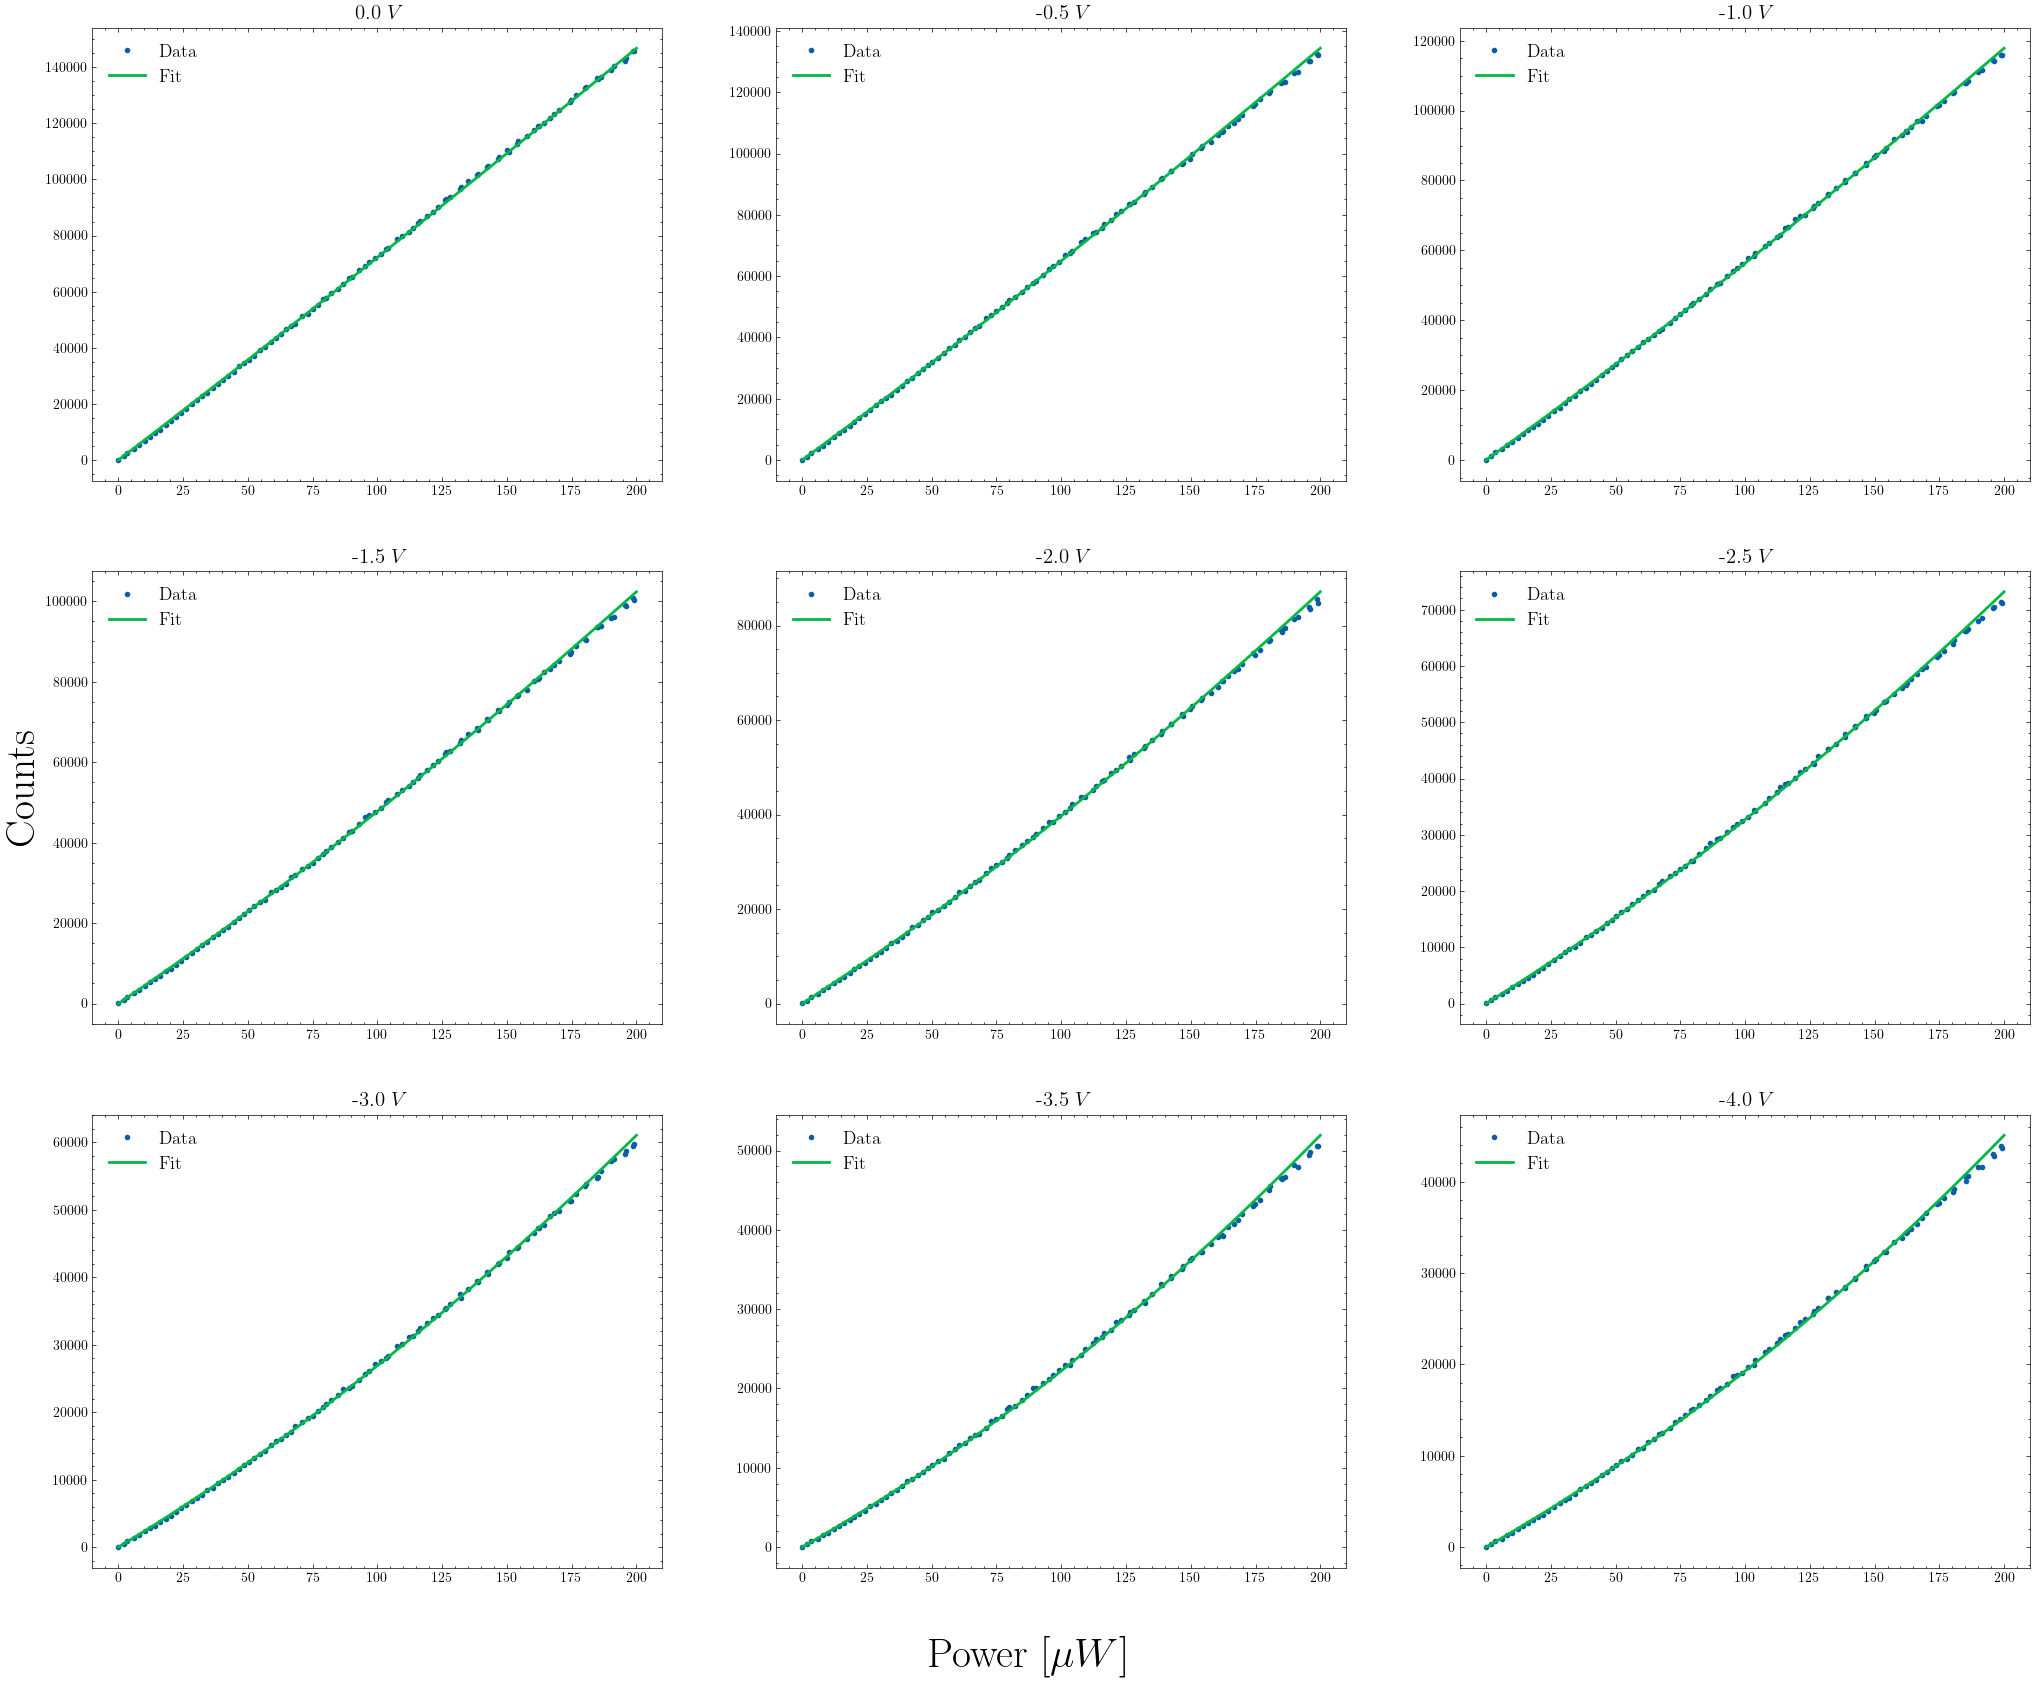

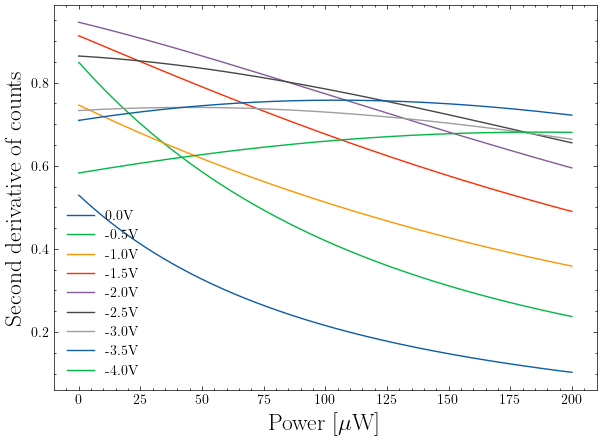

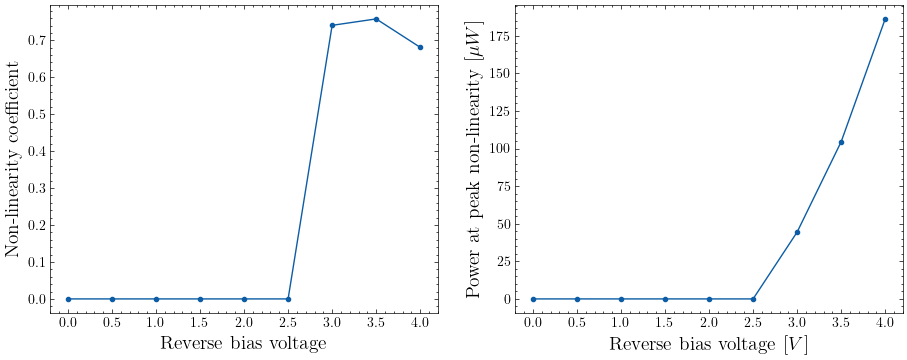

PLOTS FOR RESISTANCE 97,500
[0.529353892511139, 844.4961567762798]
[0.3320606491640483, 828.5748866903704]
[0.2105983919058279, 827.2695423911488]
[0.1840303919352799, 822.1290753073647]
[0.1643137495069948, 818.9988565909231]
[0.17446552022926584, 790.7674652525905]
[0.16516890110963092, 783.2543076622914]
[0.16565555358069353, 763.9654684833502]
[0.1555970011702728, 777.4382056056344]


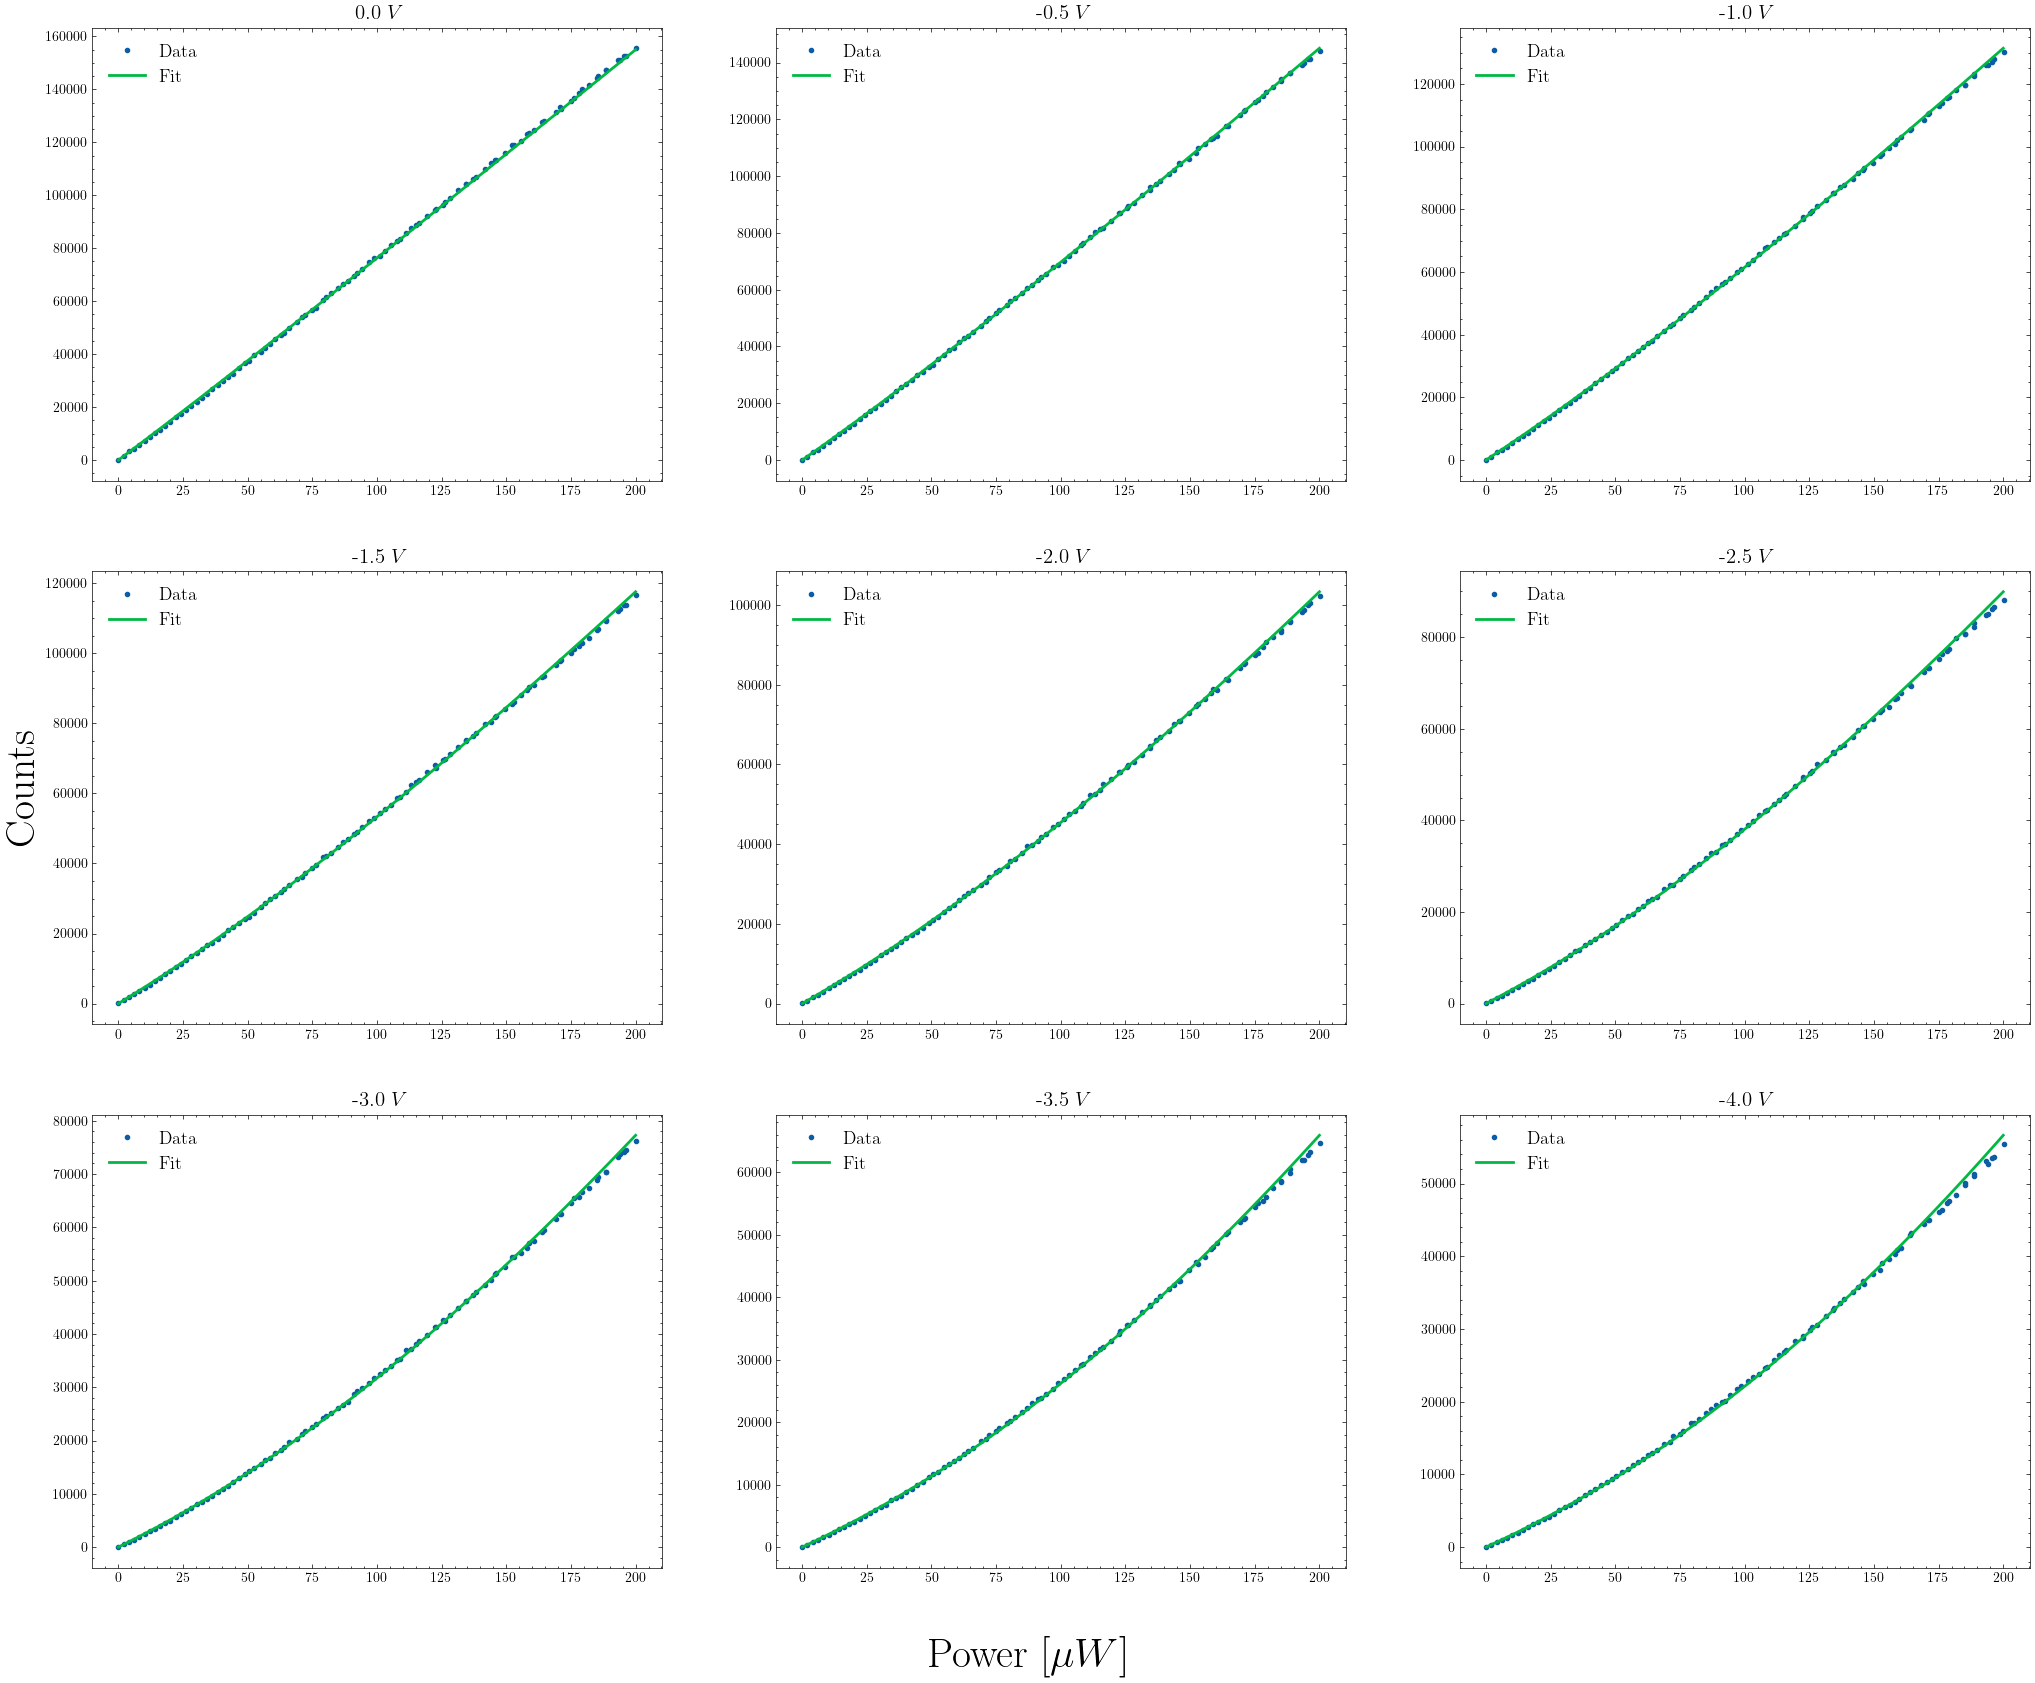

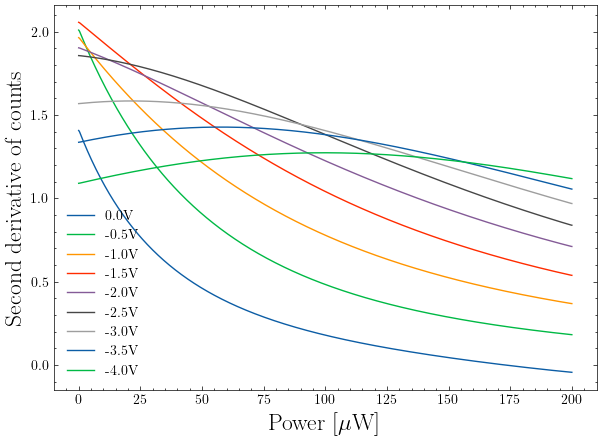

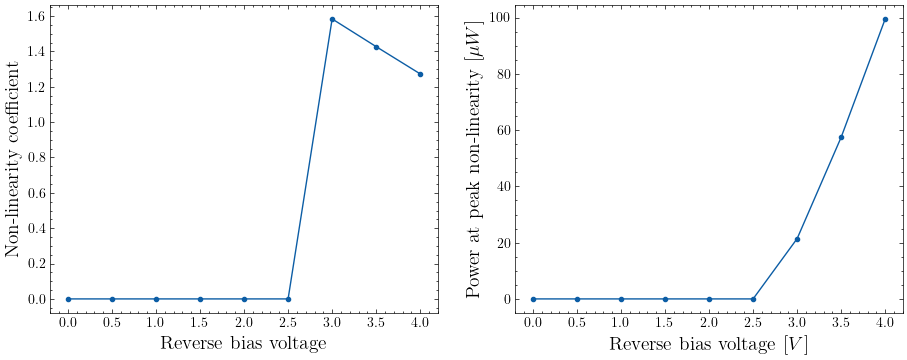

PLOTS FOR RESISTANCE 325,300
[0.18142866635178645, 861.8270737667794]
[0.18037363213424165, 840.5065188932956]
[0.12868318454954136, 836.9619273956546]
[0.11656668162334767, 827.2049814569137]
[0.11130475129049679, 816.7732328207856]
[0.10852768625266375, 804.5117772423827]
[0.11604042286346905, 769.6403178623544]
[0.10555865277160806, 775.1381027616295]
[0.10280875991364431, 767.1469644932374]


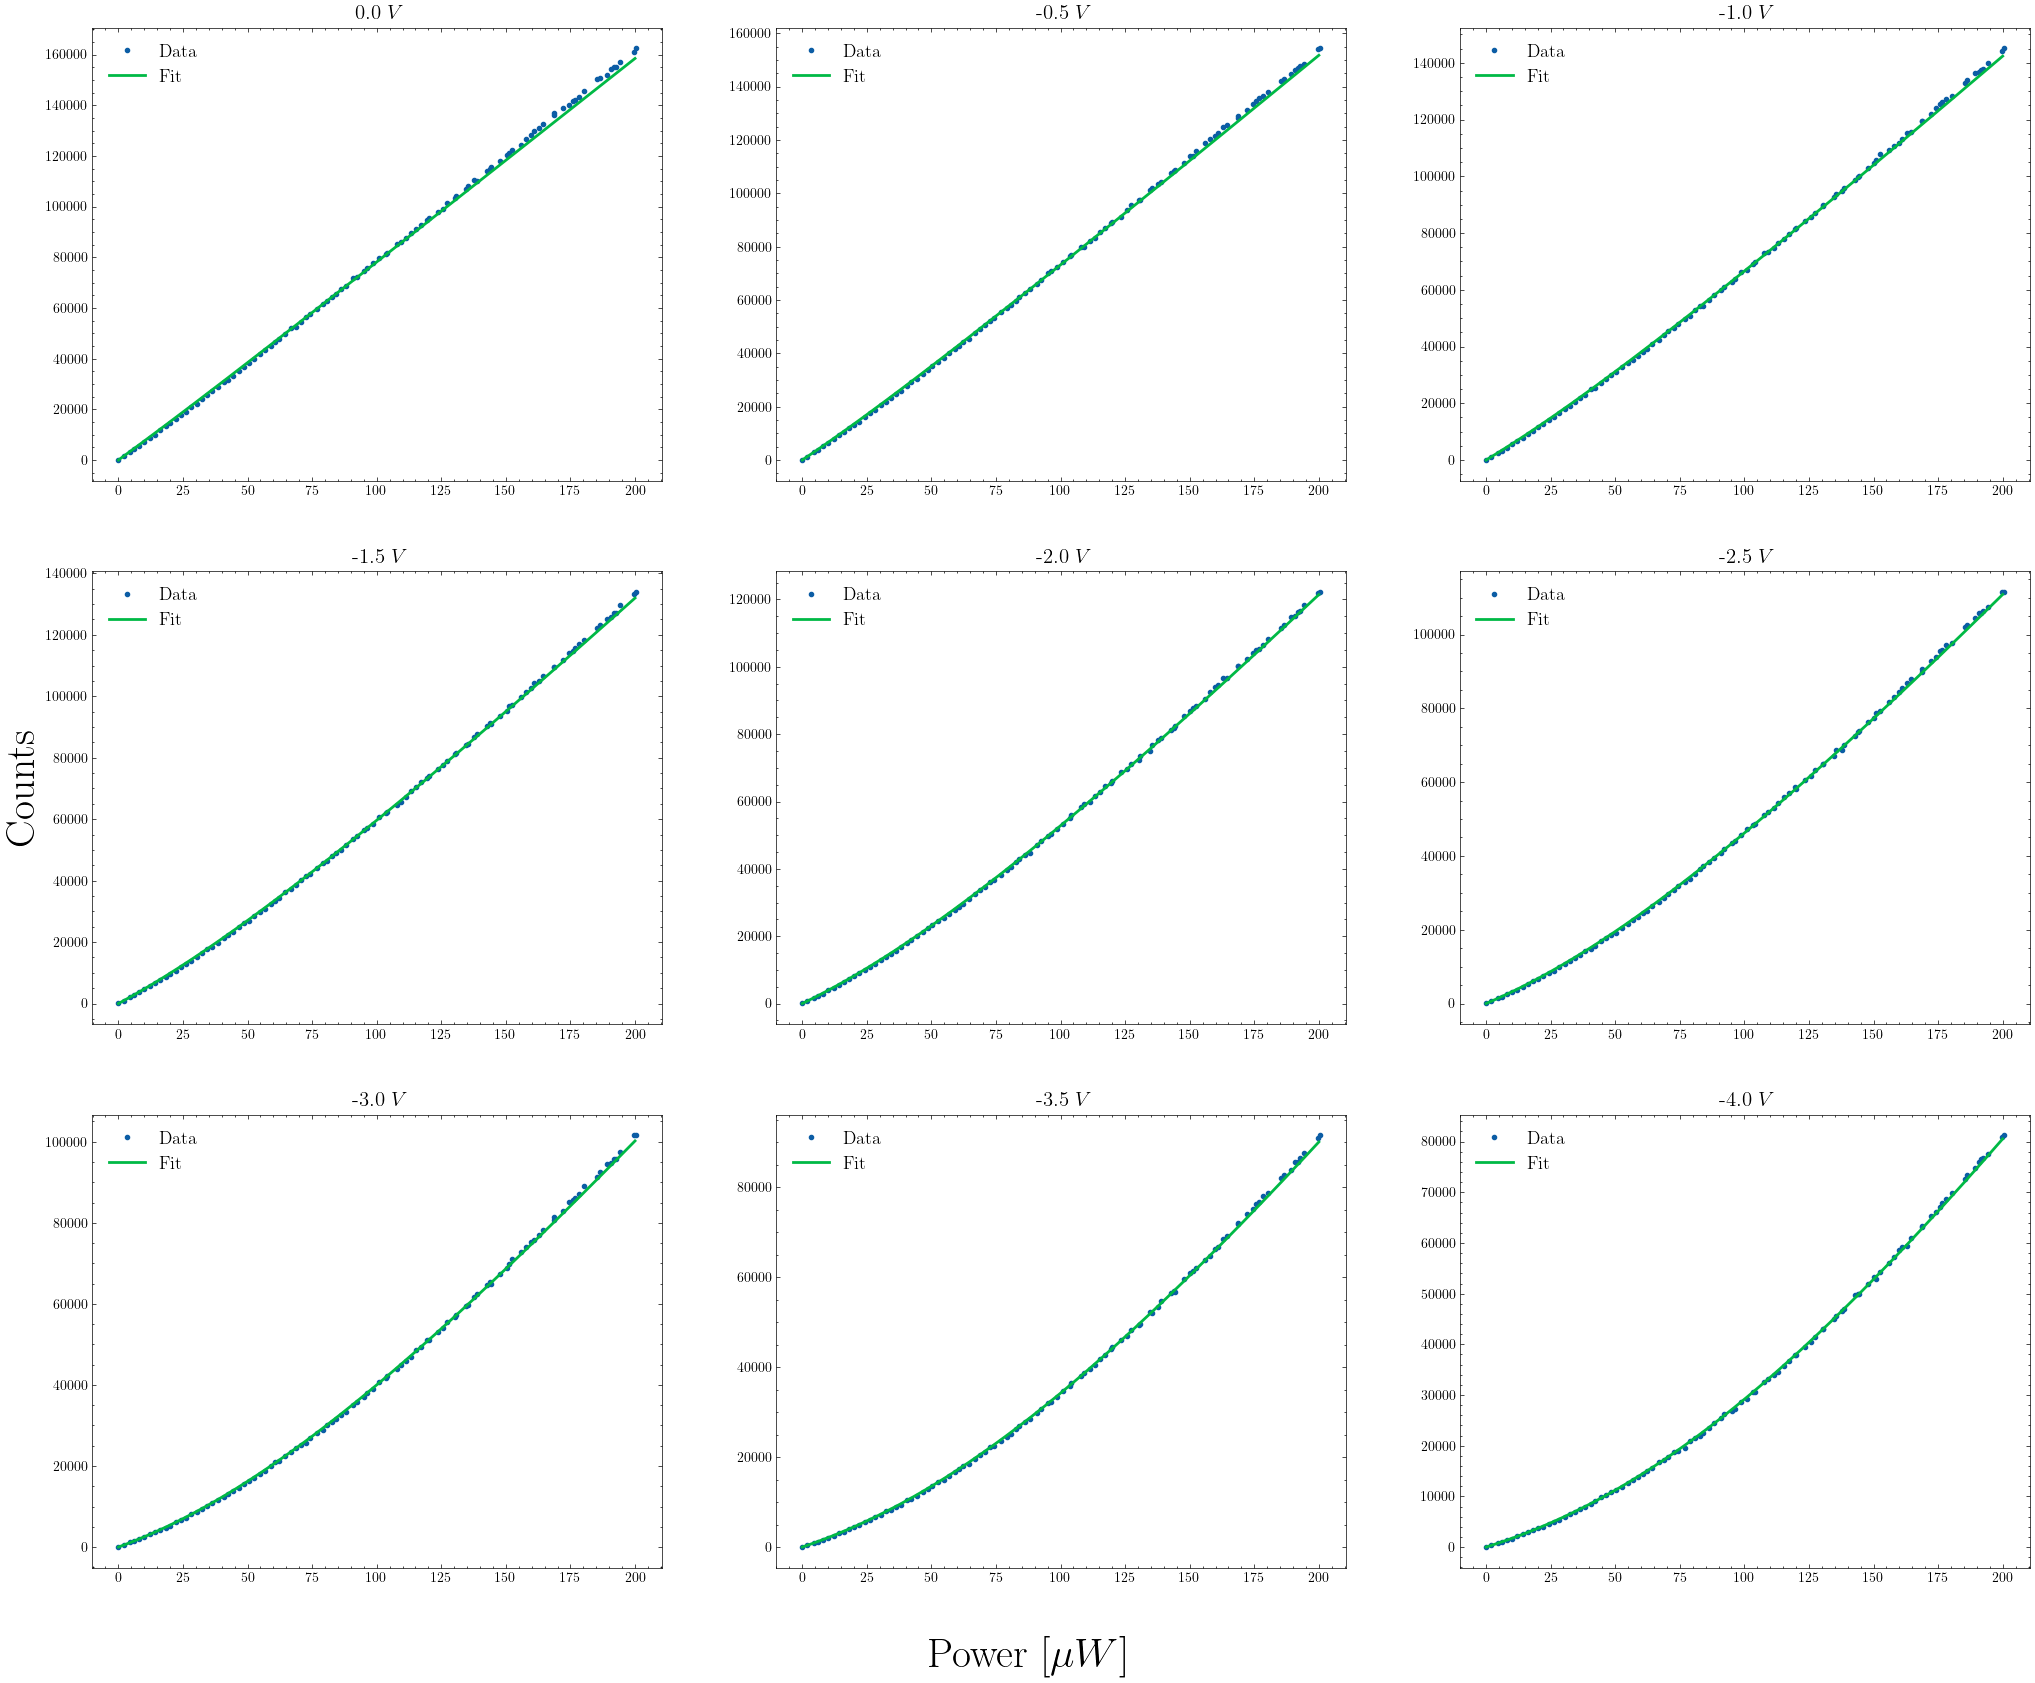

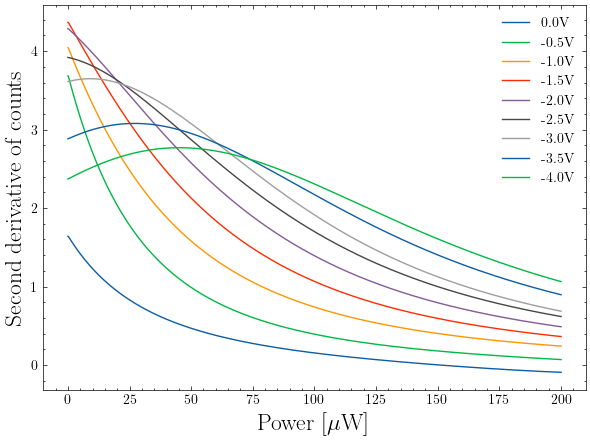

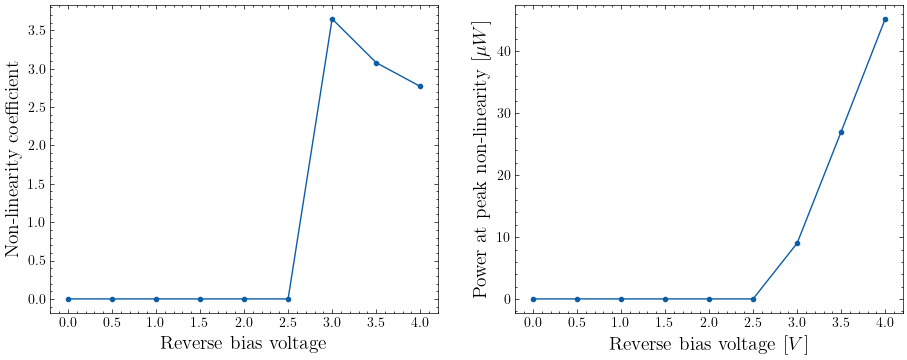

PLOTS FOR RESISTANCE 552,000
[0.11013153396662281, 948.0622283550728]
[0.1127334809698187, 935.6074978841772]
[0.0990468948762139, 928.2546380036672]
[0.10000764508676556, 912.1927936828054]
[0.09515780669688803, 903.6319068138481]
[0.09765666991251112, 883.7684571084103]
[0.09750833407768472, 866.1189210116098]
[0.0990160741020137, 842.987640805936]
[0.09715381035079759, 829.891226765982]


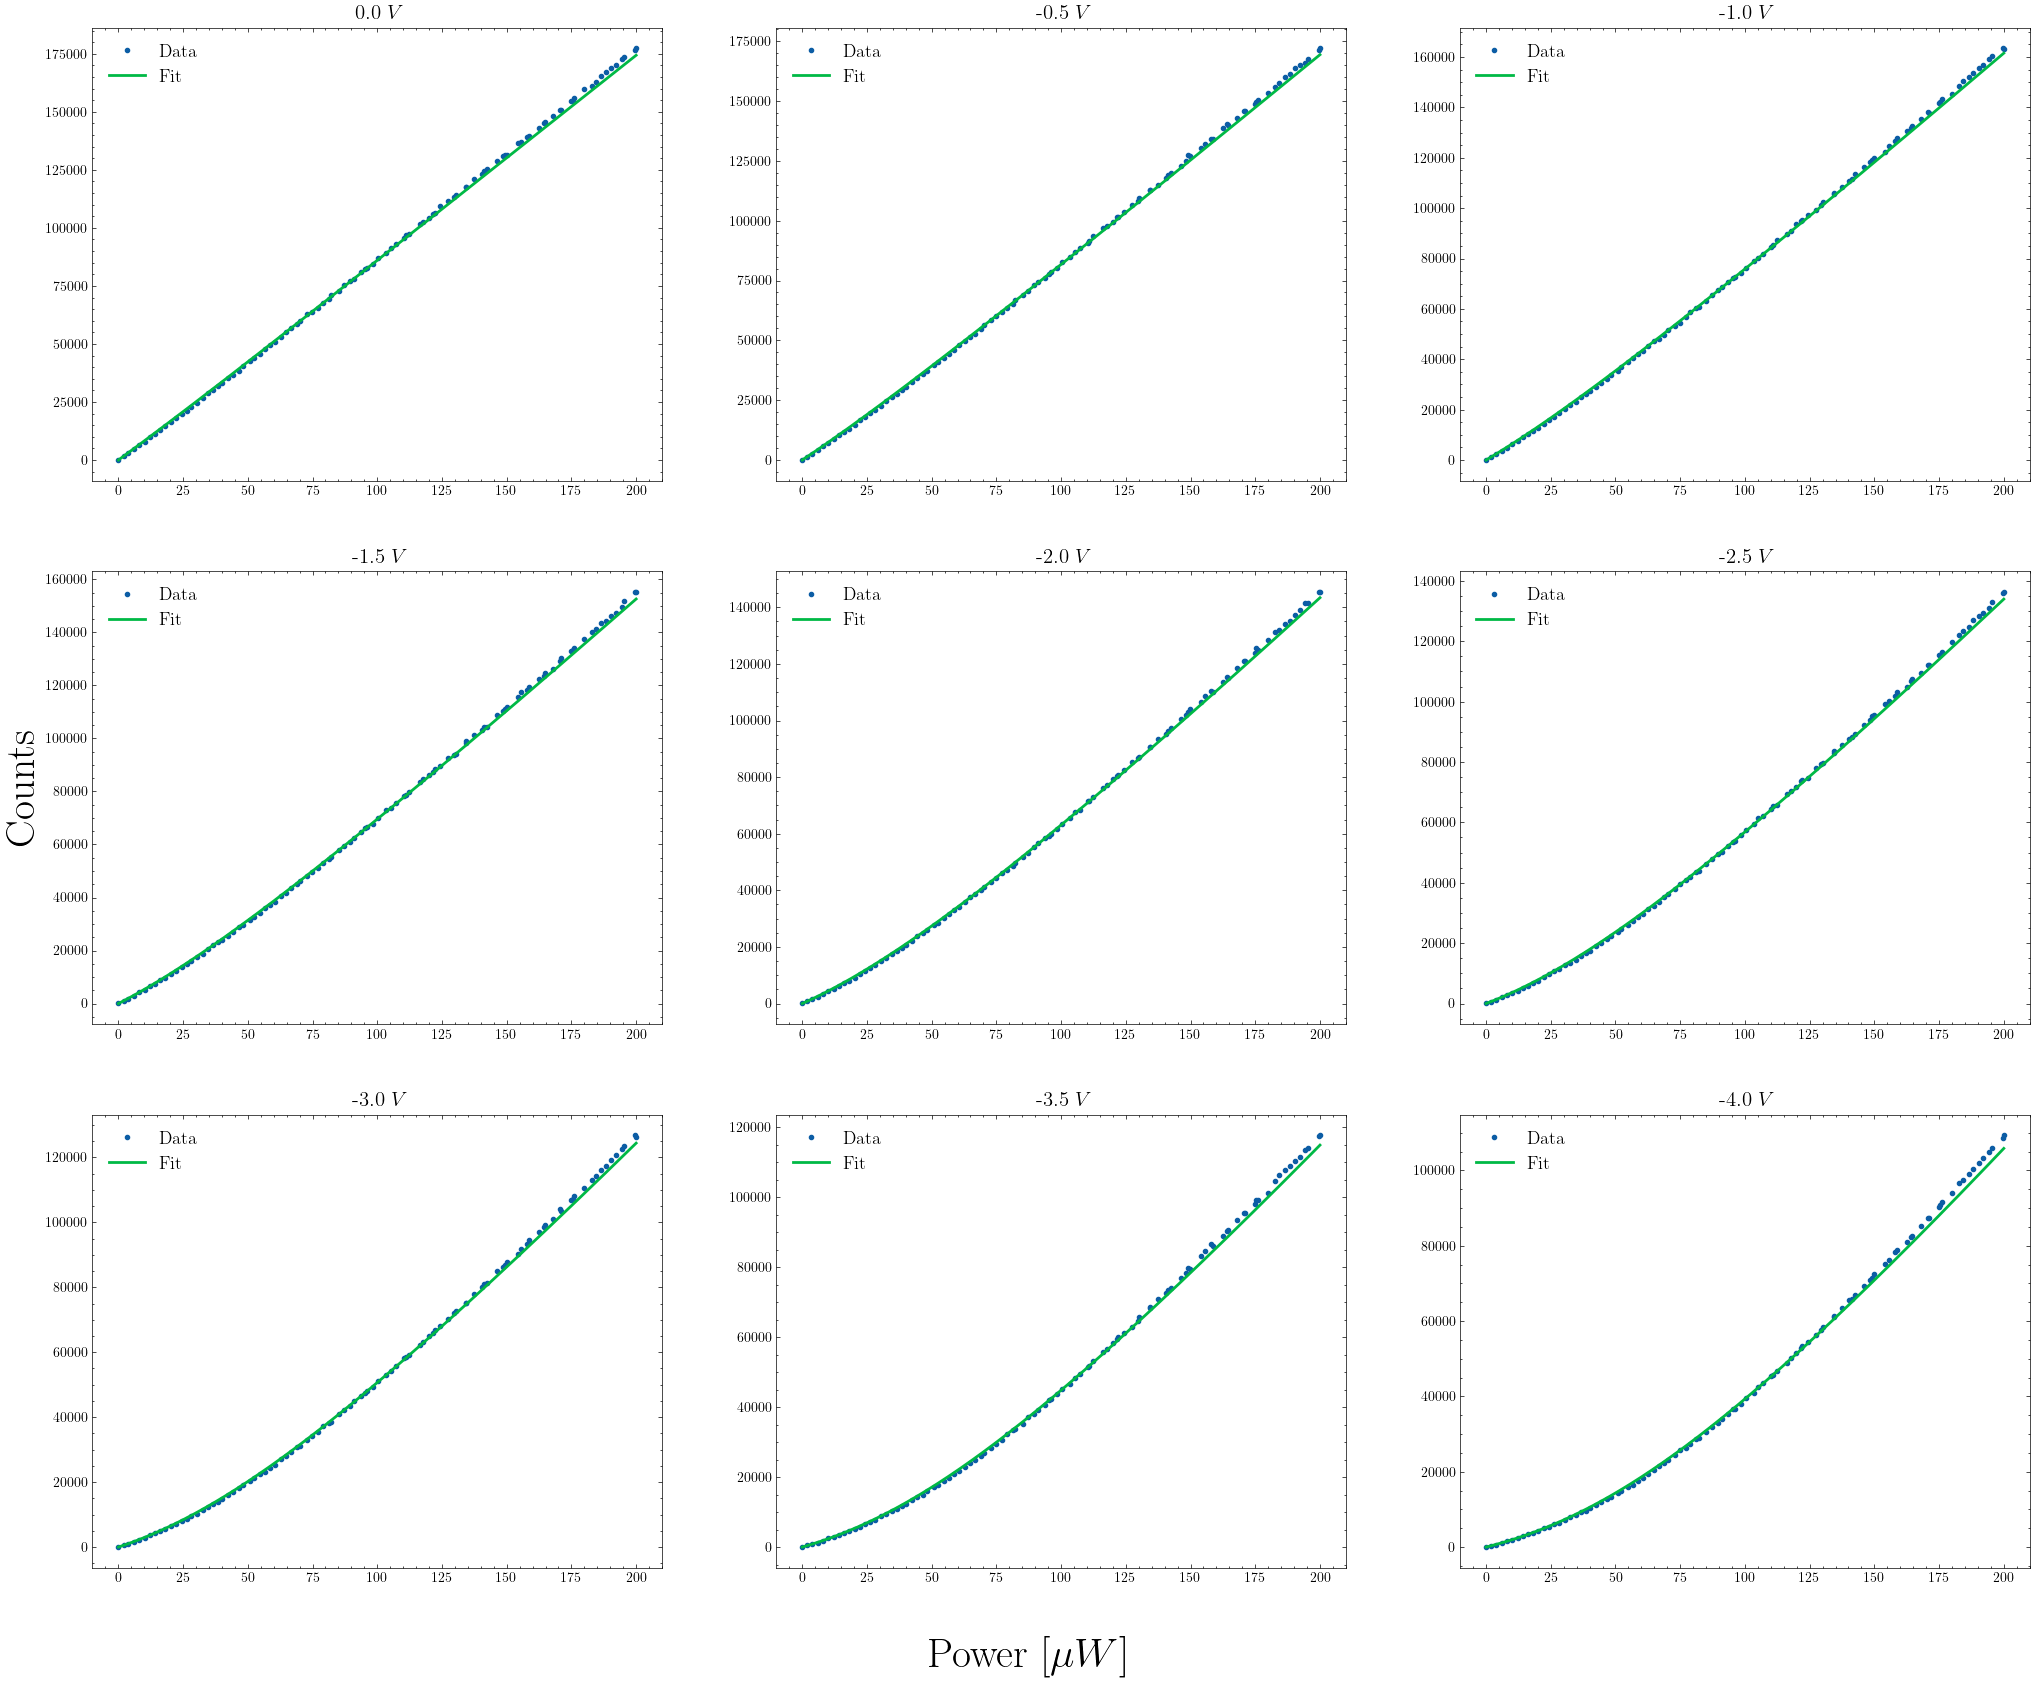

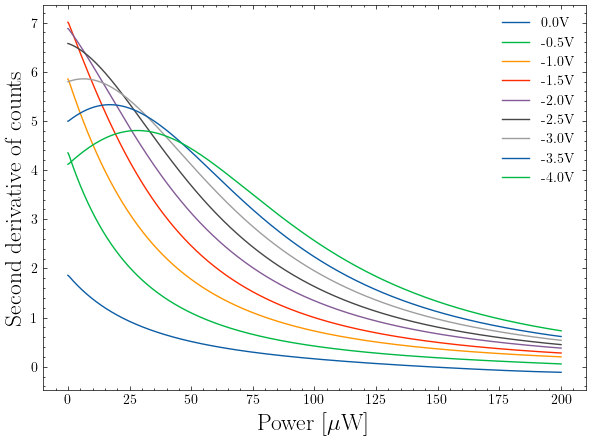

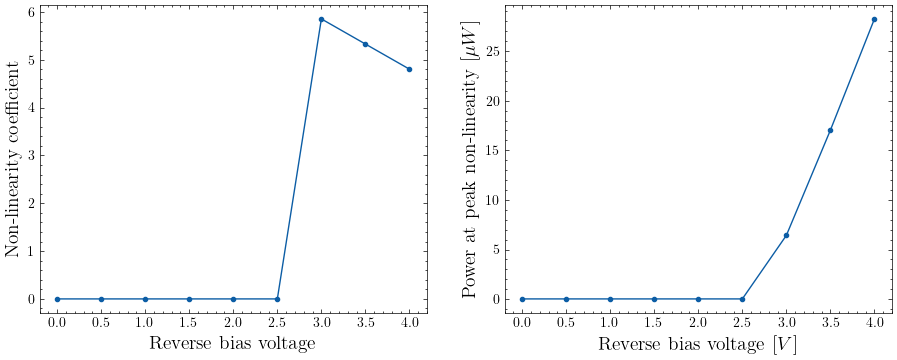

PLOTS FOR RESISTANCE 677,000
[0.0835471302349756, 952.1096022136843]
[0.07753252918079762, 954.2500453209786]
[0.08061537182162805, 946.8203715580806]
[0.08085774591254474, 939.6082290963806]
[0.0800144686244971, 932.631314487025]
[0.08245060120015299, 916.8119806892785]
[0.08447391414153291, 899.6219384162089]
[0.08860584333123356, 869.0886642396314]
[0.086032061325499, 863.8050338928211]


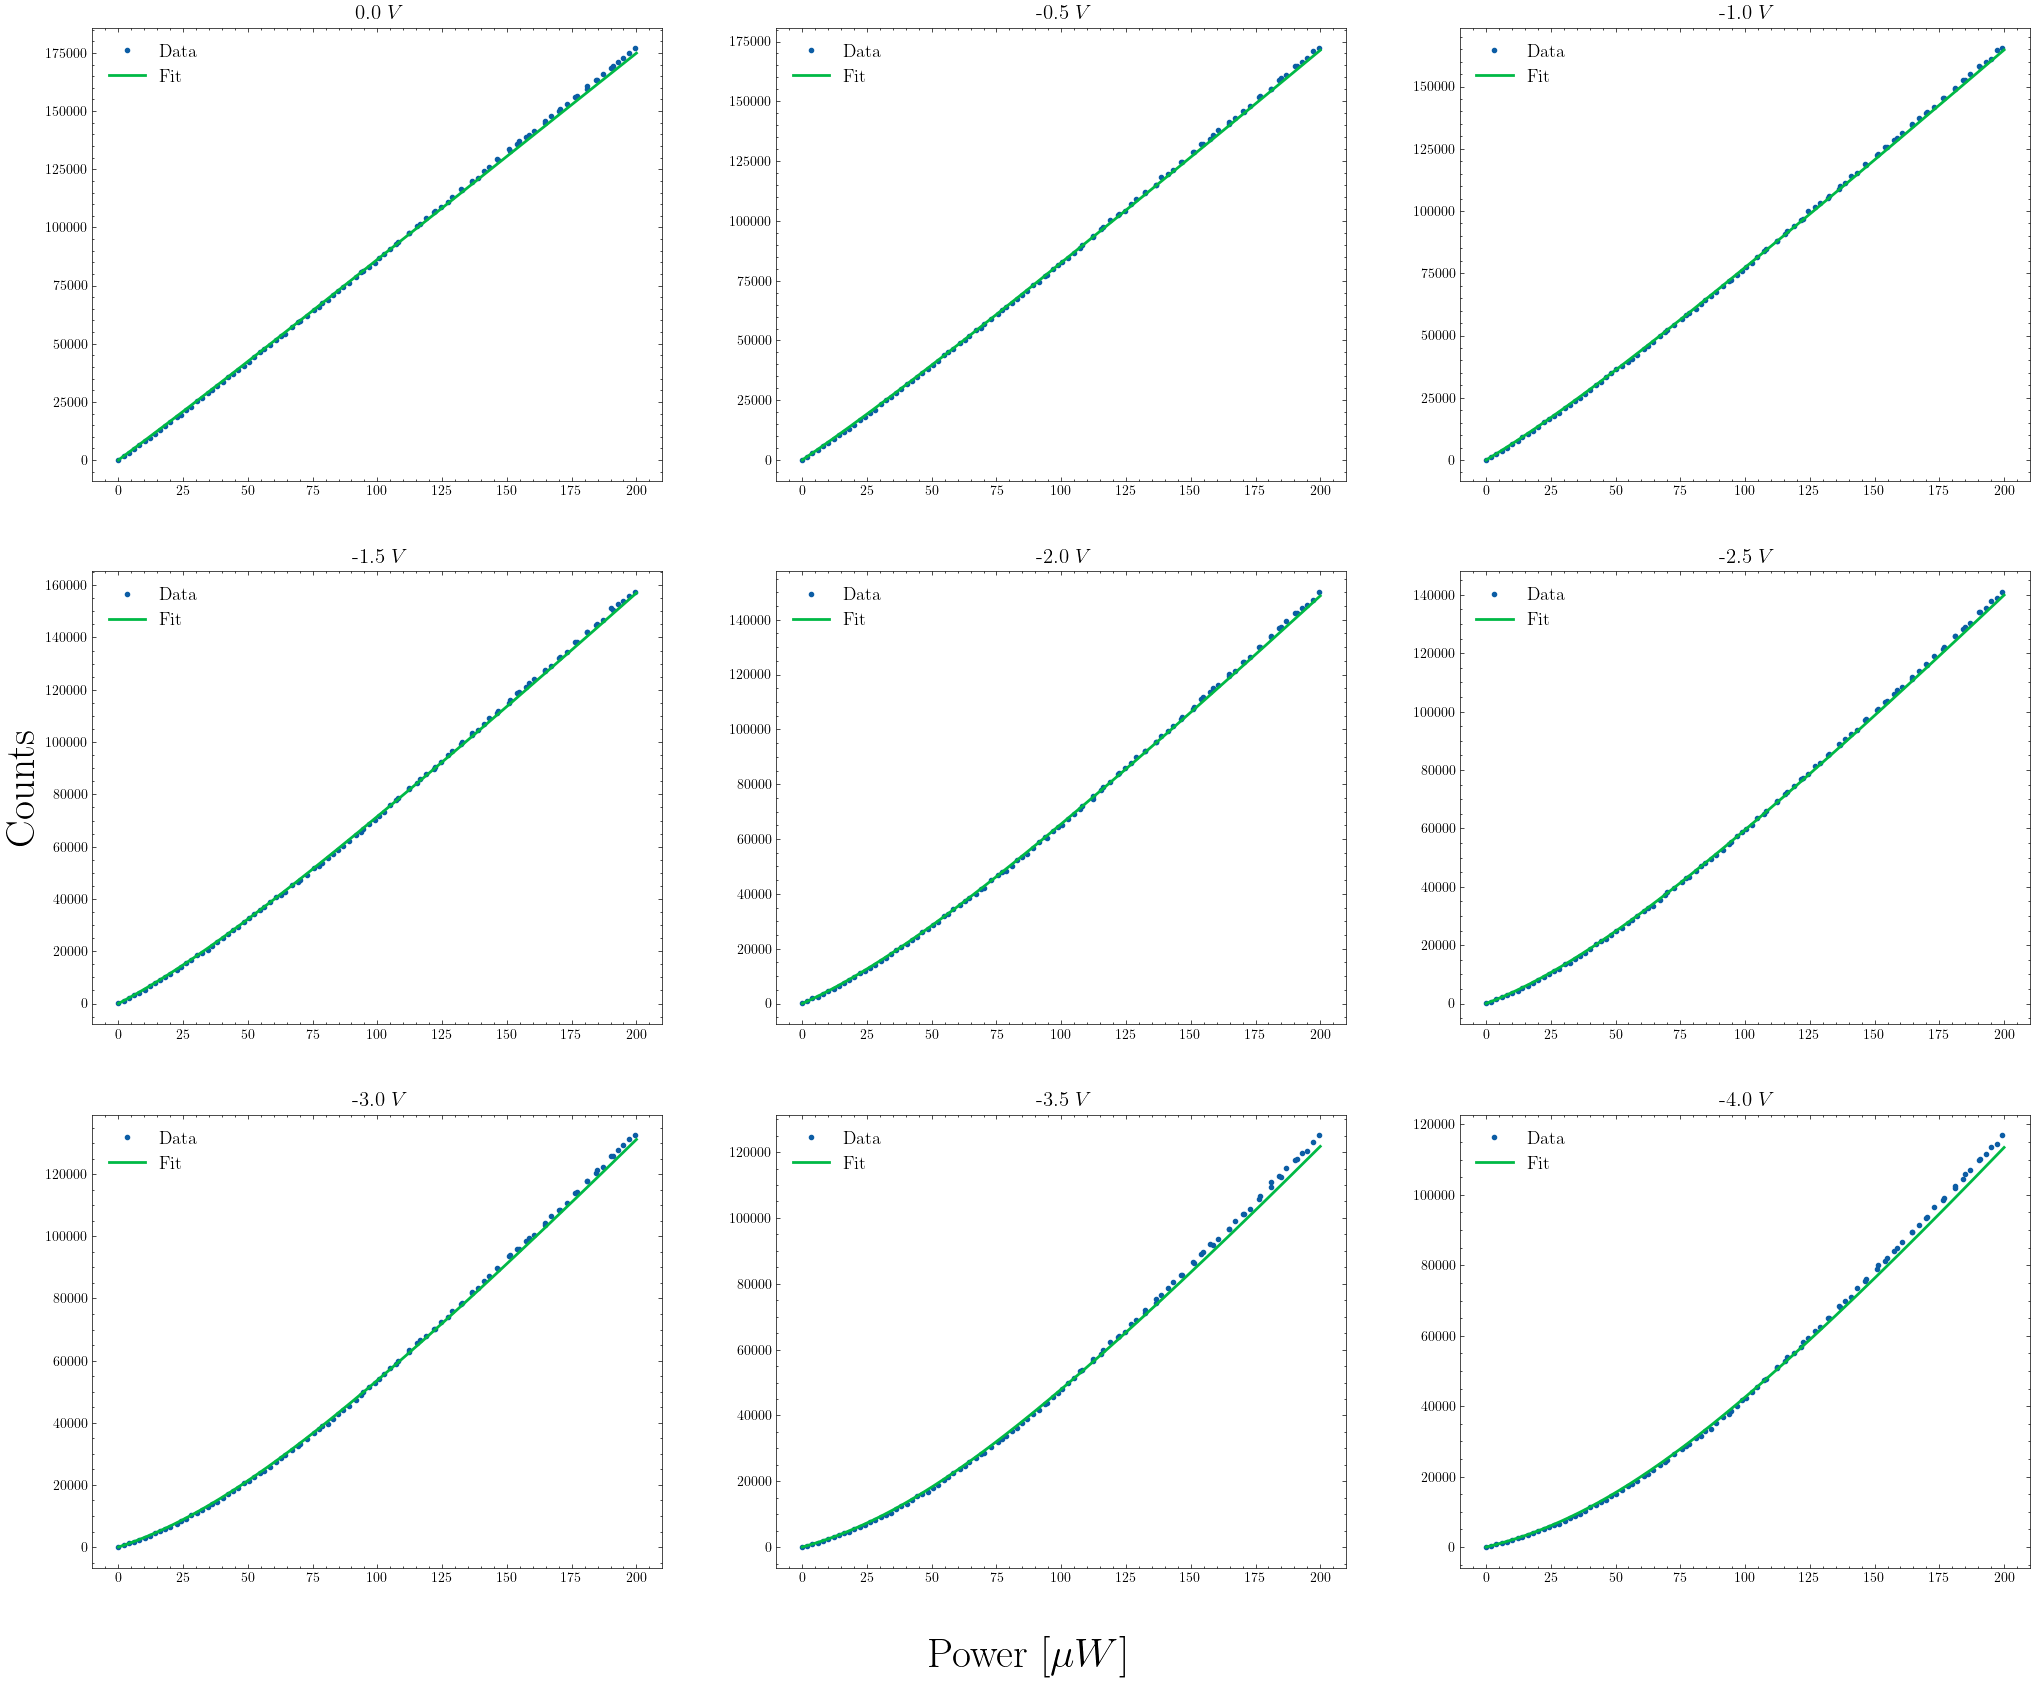

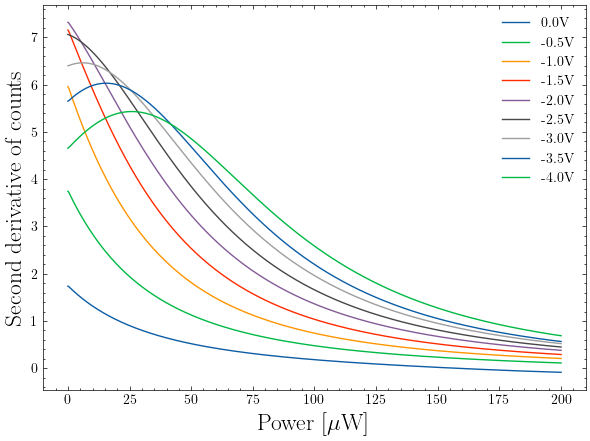

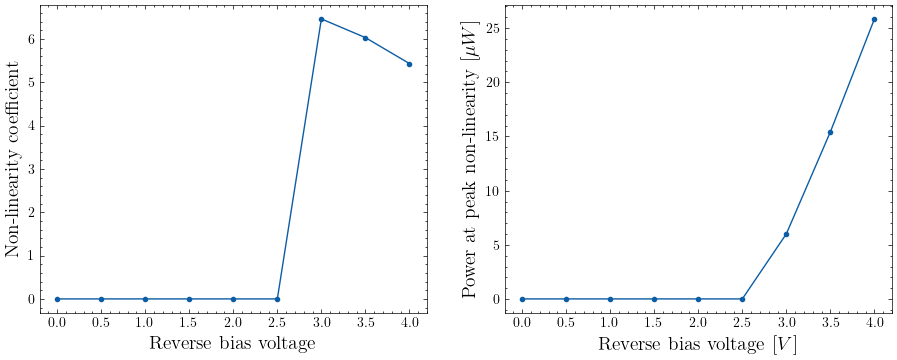

PLOTS FOR RESISTANCE 807,000
[0.07349880901078573, 922.4859686648851]
[0.06906316848844074, 924.7307507593582]
[0.07865211813539456, 910.9453129202453]
[0.07764545807560283, 905.4893729425152]
[0.07368249263231794, 908.275022242584]
[0.07727028126698533, 893.6086101208035]
[0.08219766789083048, 870.0943776818852]
[0.08163851995598992, 863.2041188087318]
[0.08245073551715908, 847.7439419867355]


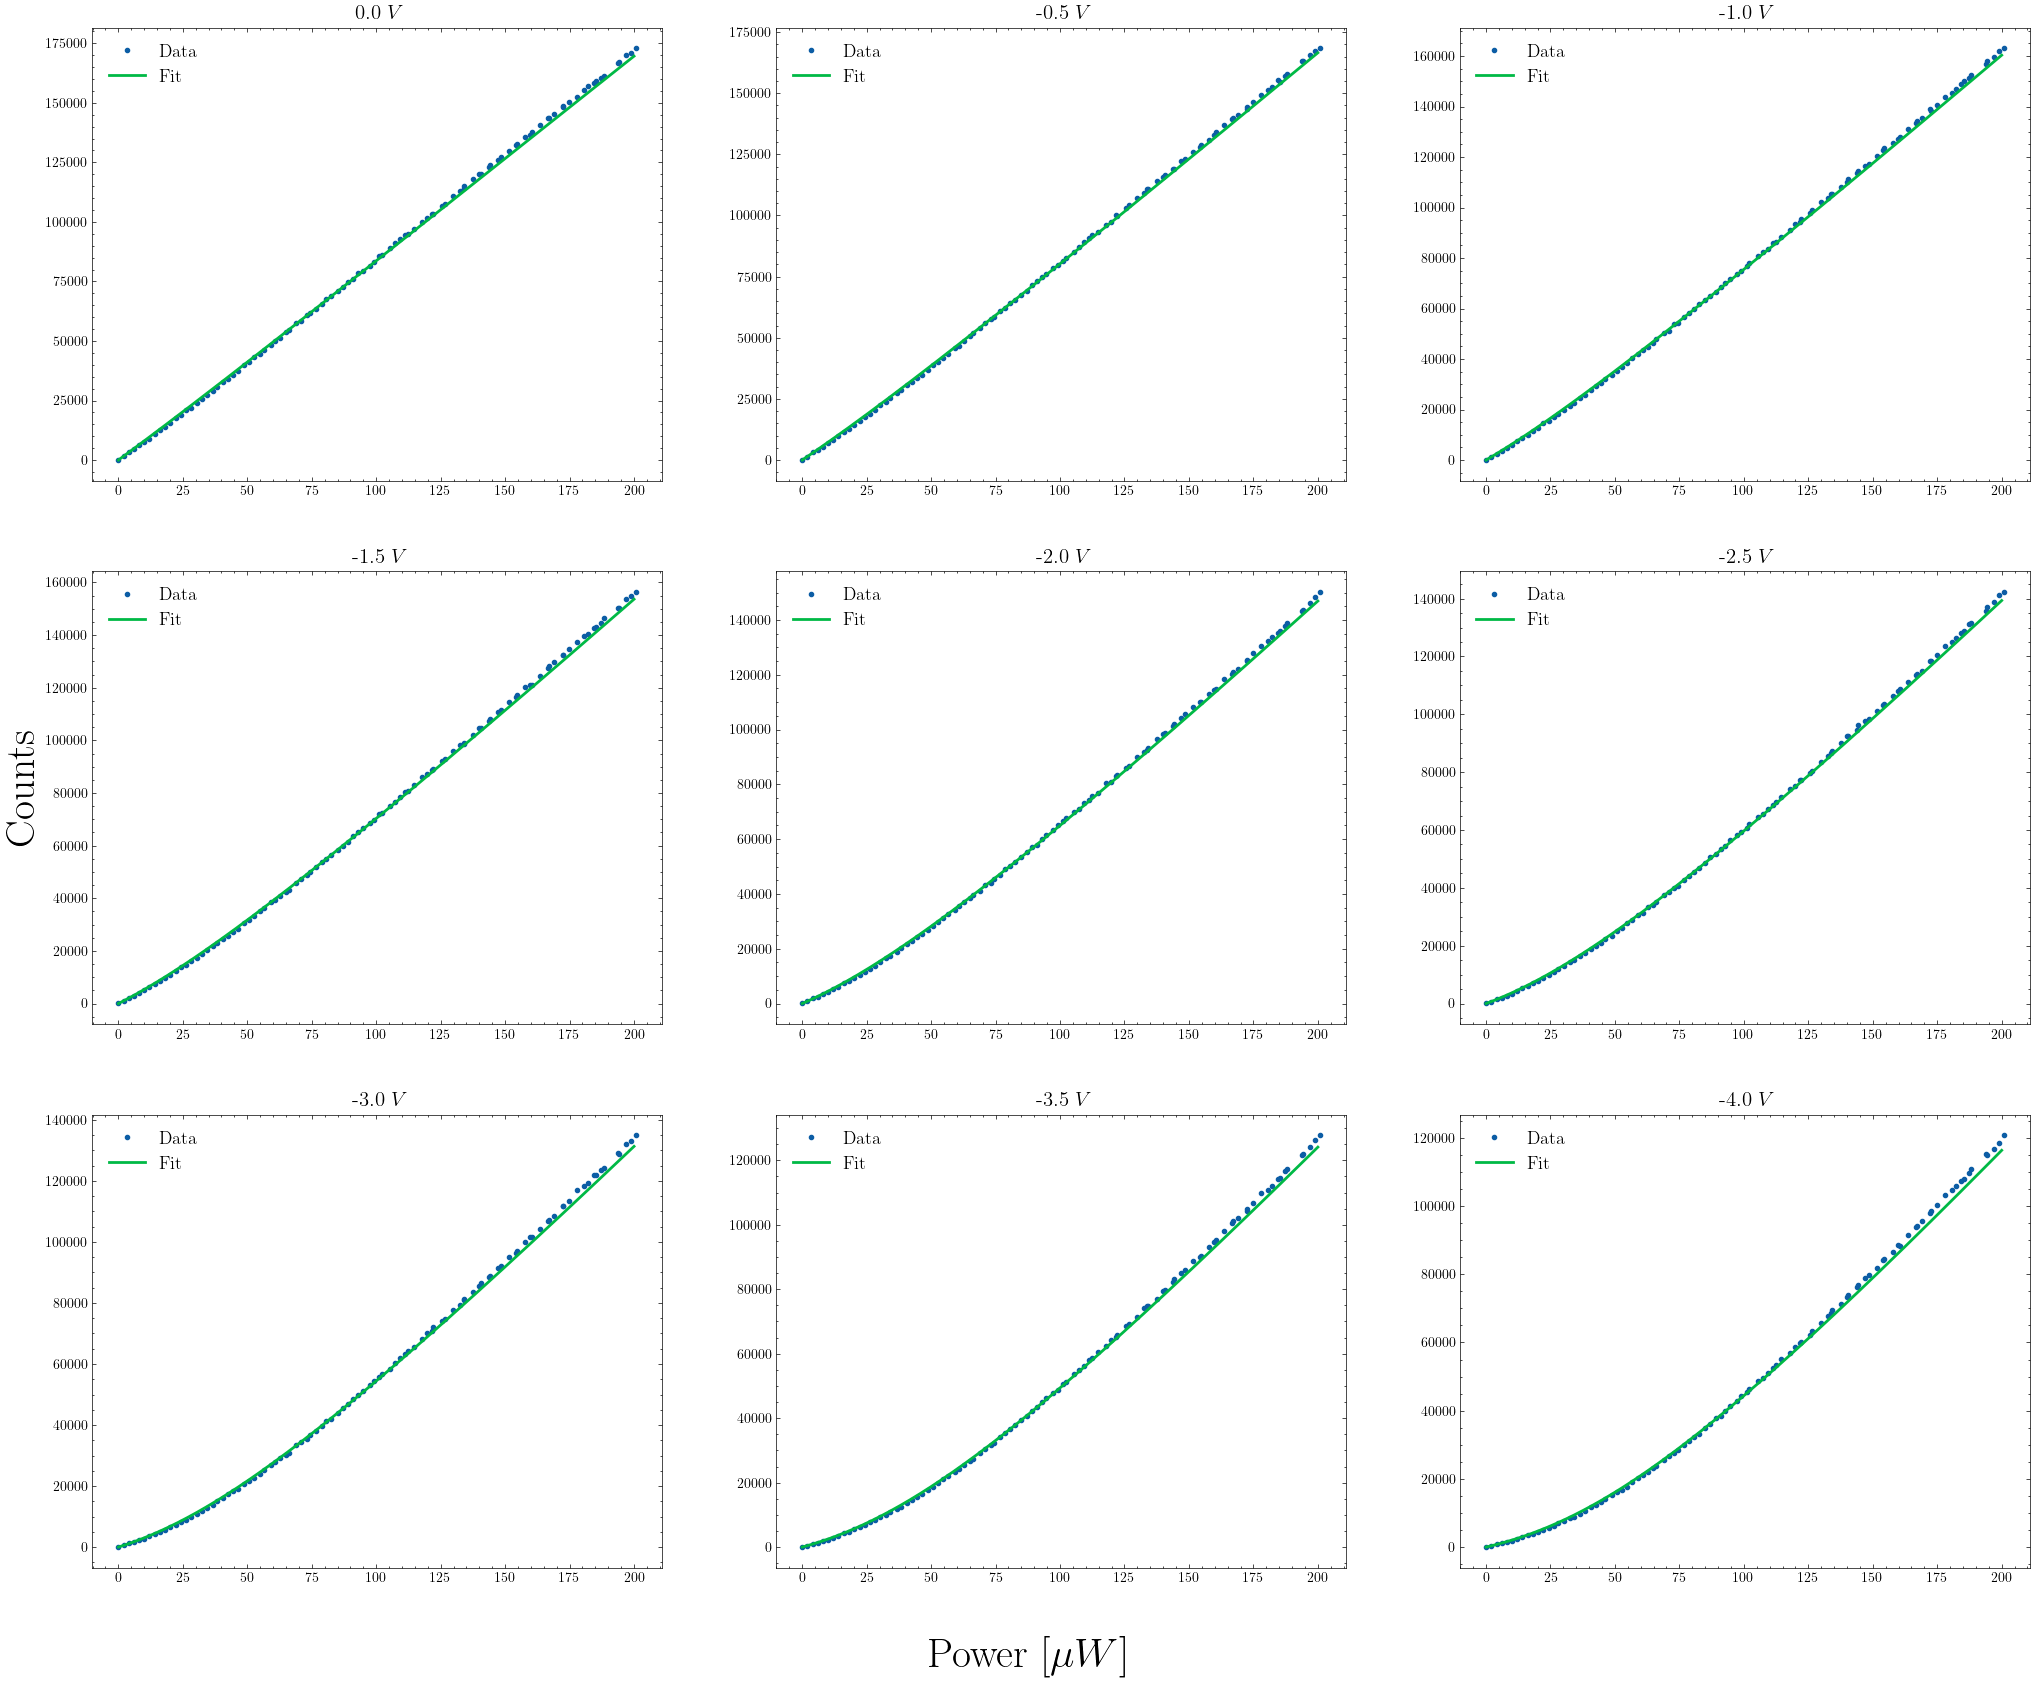

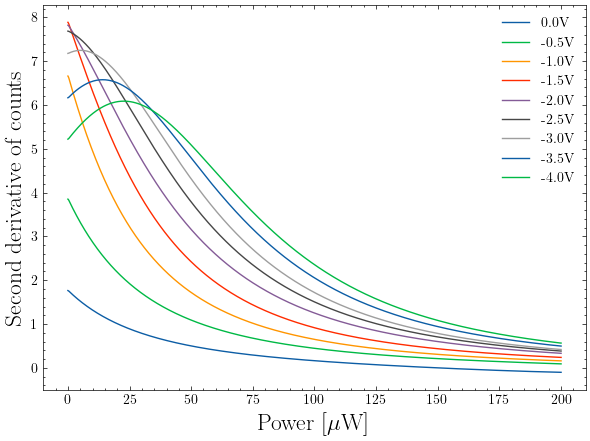

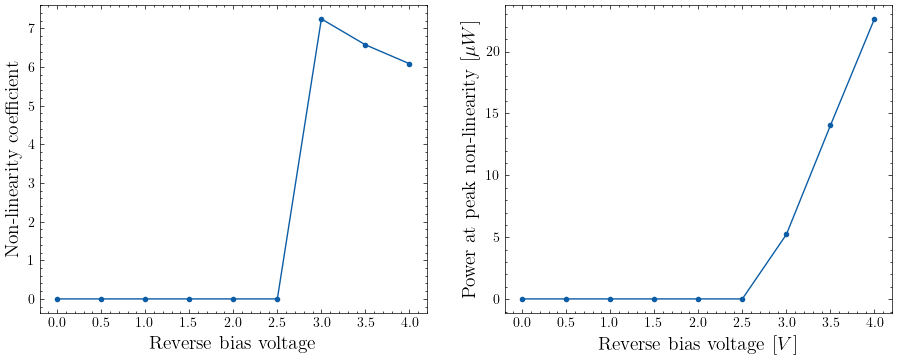

PLOTS FOR RESISTANCE 1,000,000
[0.06623876136109742, 940.332555378709]
[0.07230164559468615, 936.9834599319871]
[0.07569193249535129, 926.5236962104501]
[0.061855894600640796, 947.481714938361]
[0.06981761684665905, 927.3336885270344]
[0.06619333155505888, 935.4786967331481]
[0.06989732682717172, 921.0107601519262]
[0.0751719557180598, 892.0773437567377]
[0.0774138316413578, 873.685564306397]


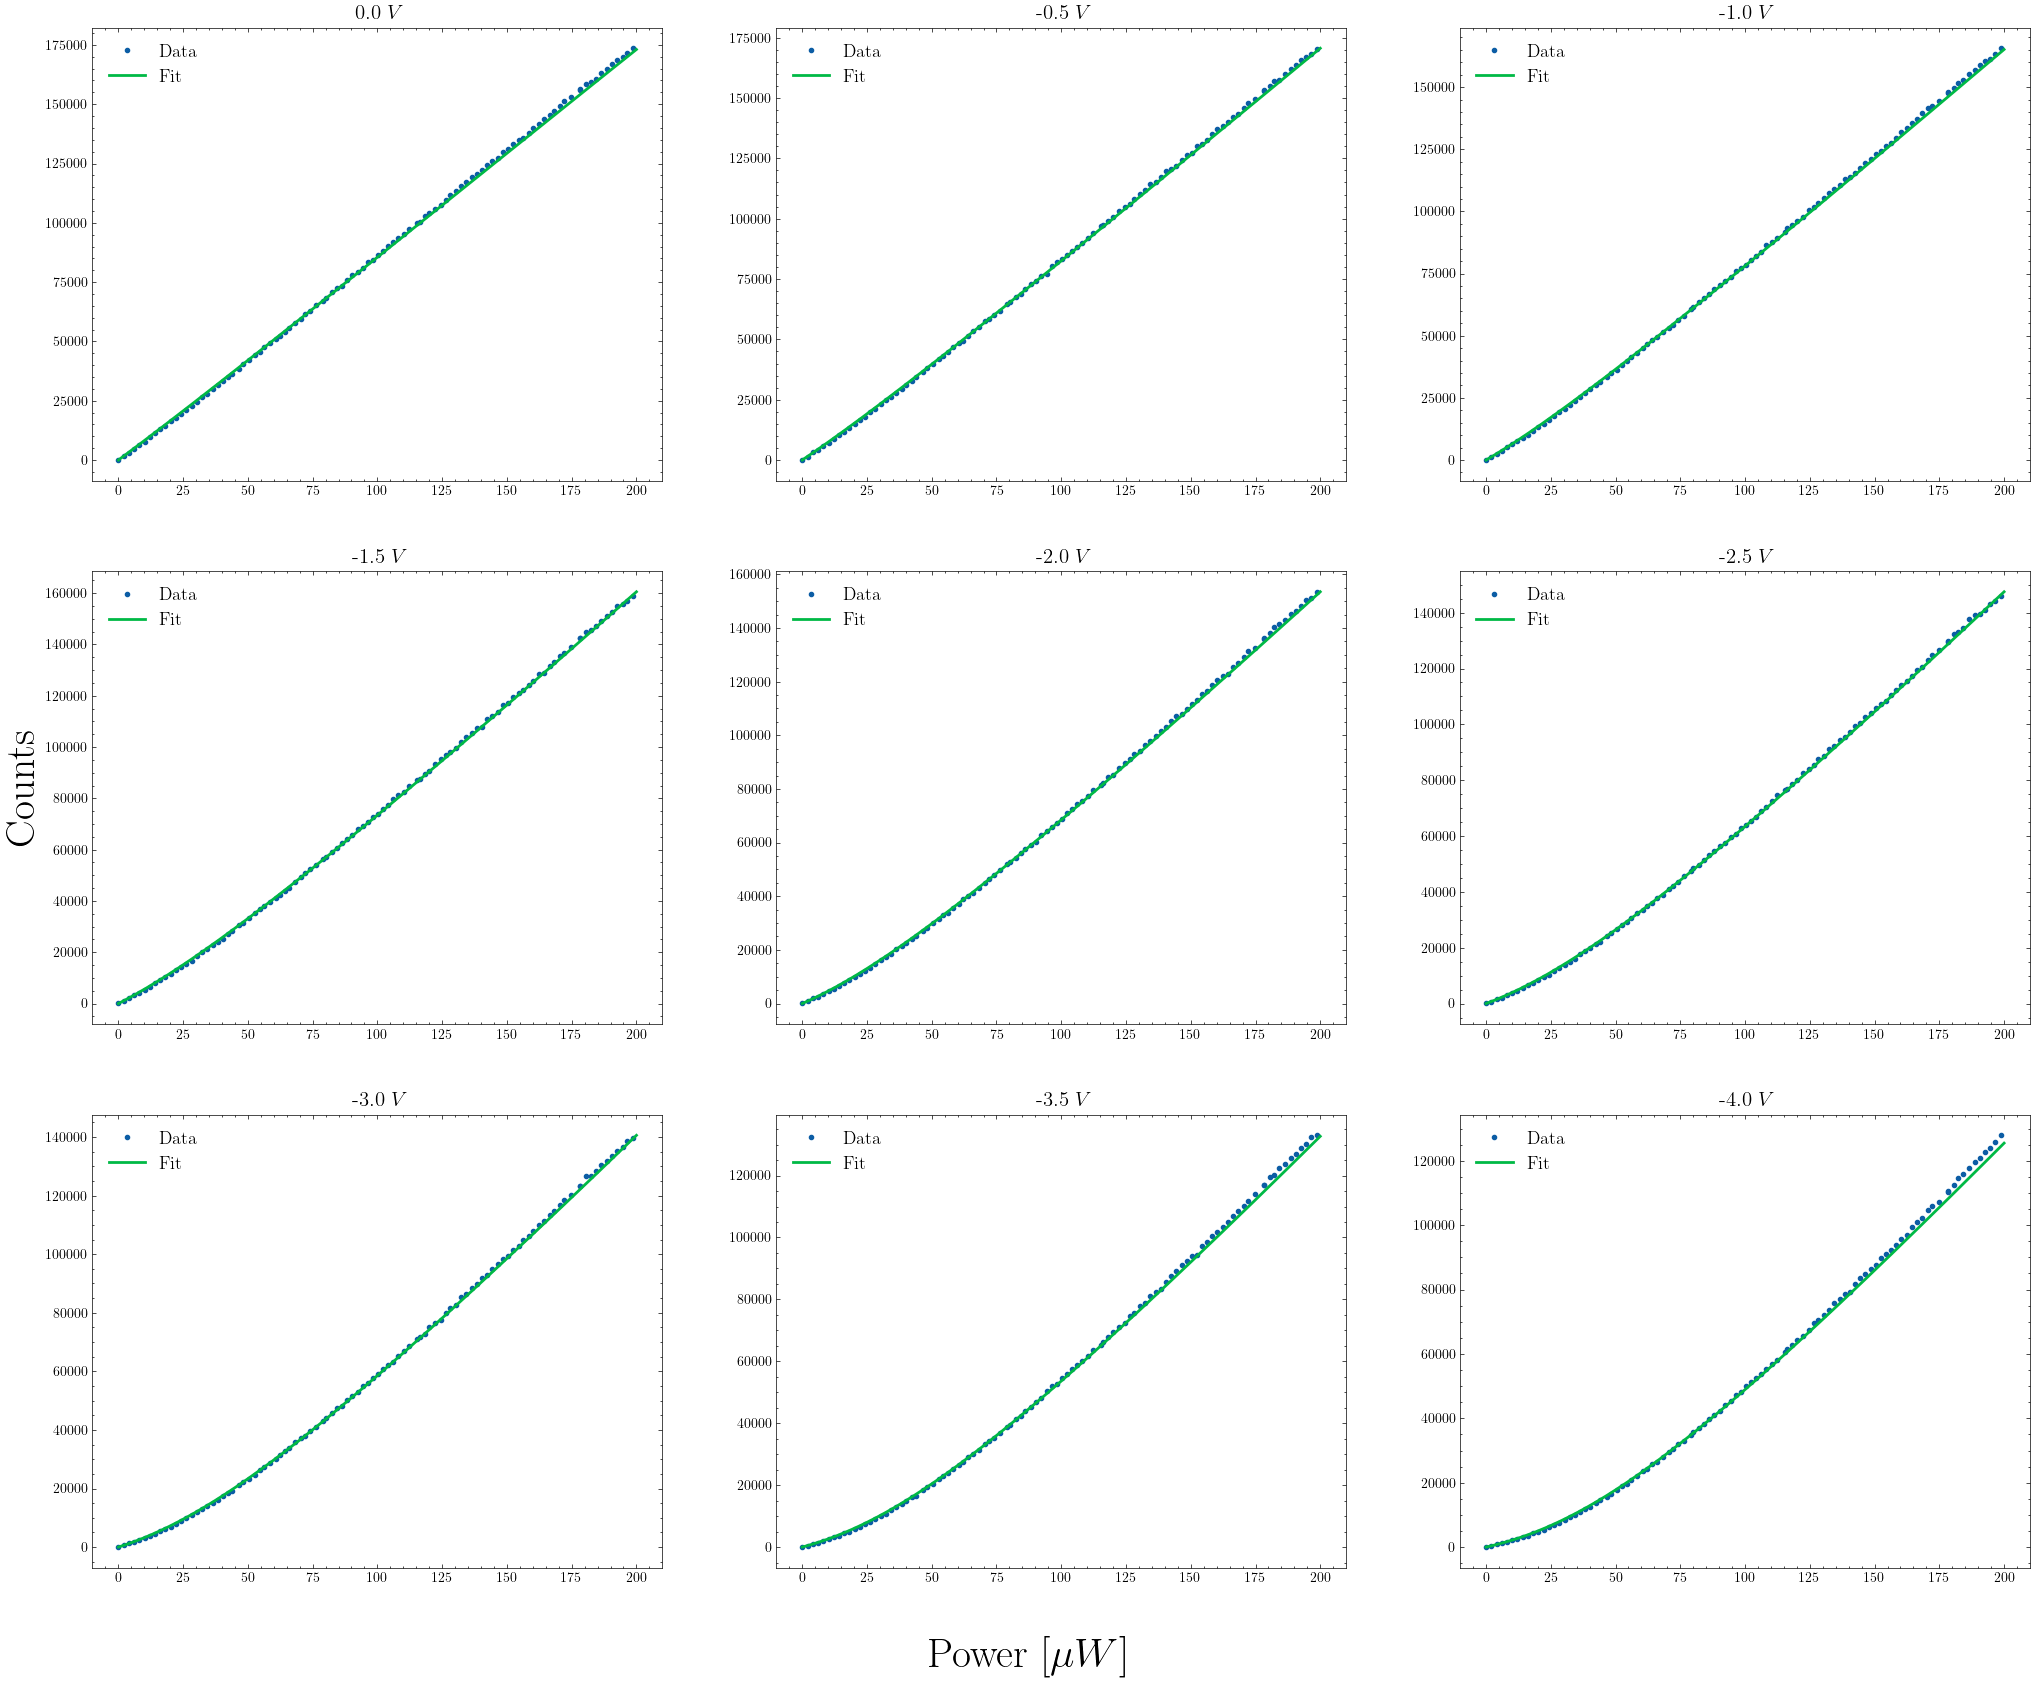

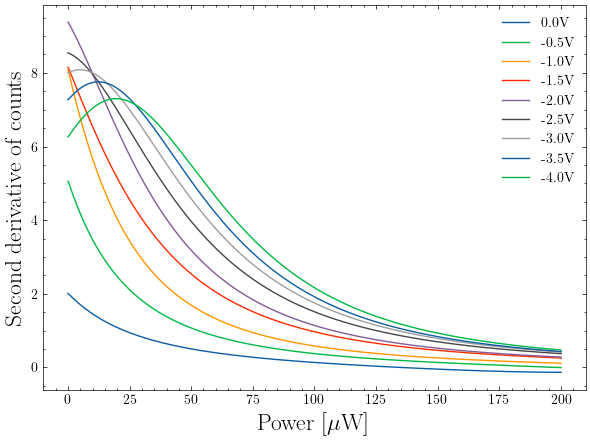

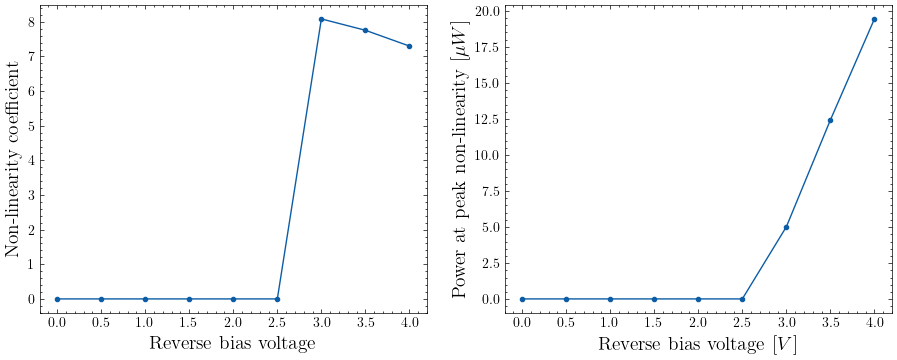

PLOTS FOR RESISTANCE 3,012,000


/home/ali/Code/Master's project/data_analysis/utilities.py:144: RuntimeWarning: invalid value encountered in power
  beta1 = 1.1e5 * (Eg - Eph) * (2 * mu1) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:145: RuntimeWarning: invalid value encountered in power
  beta2 = 1.1e5 * (Eg - Eph) * (2 * mu2) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:158: RuntimeWarning: invalid value encountered in power
  FKa = (a1 + a2) * F ** (1 / 3) * 1e4 / n
/home/ali/Code/Master's project/data_analysis/utilities.py:226: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  alpha = fsolve(func, self.alphas[-1])[0]
/home/ali/Code/Master's project/data_analysis/utilities.py:166: RuntimeWarning: invalid value encountered in sqrt
  depletion_width = 1e-7 * np.sqrt(1e4 + 795.5 * (1.4 - V_d))


[0.0026905285689735057, 871.9737907081562]
Fit with resistance 3012000 and voltage 0.0 was not completely successful.
[0.009993203929603395, 850.3593737226314]
Fit with resistance 3012000 and voltage -0.5 was not completely successful.
[0.030005986335929633, 914.4718019880357]
[0.03478165613657991, 919.750687020521]
[0.04102021524521243, 913.1275930345367]
[0.045461997590418496, 906.6653767180978]
[0.047013077751198125, 908.6566901832982]
[0.05200315028132637, 892.1661565250242]
[0.05139697390145255, 900.8753280749676]


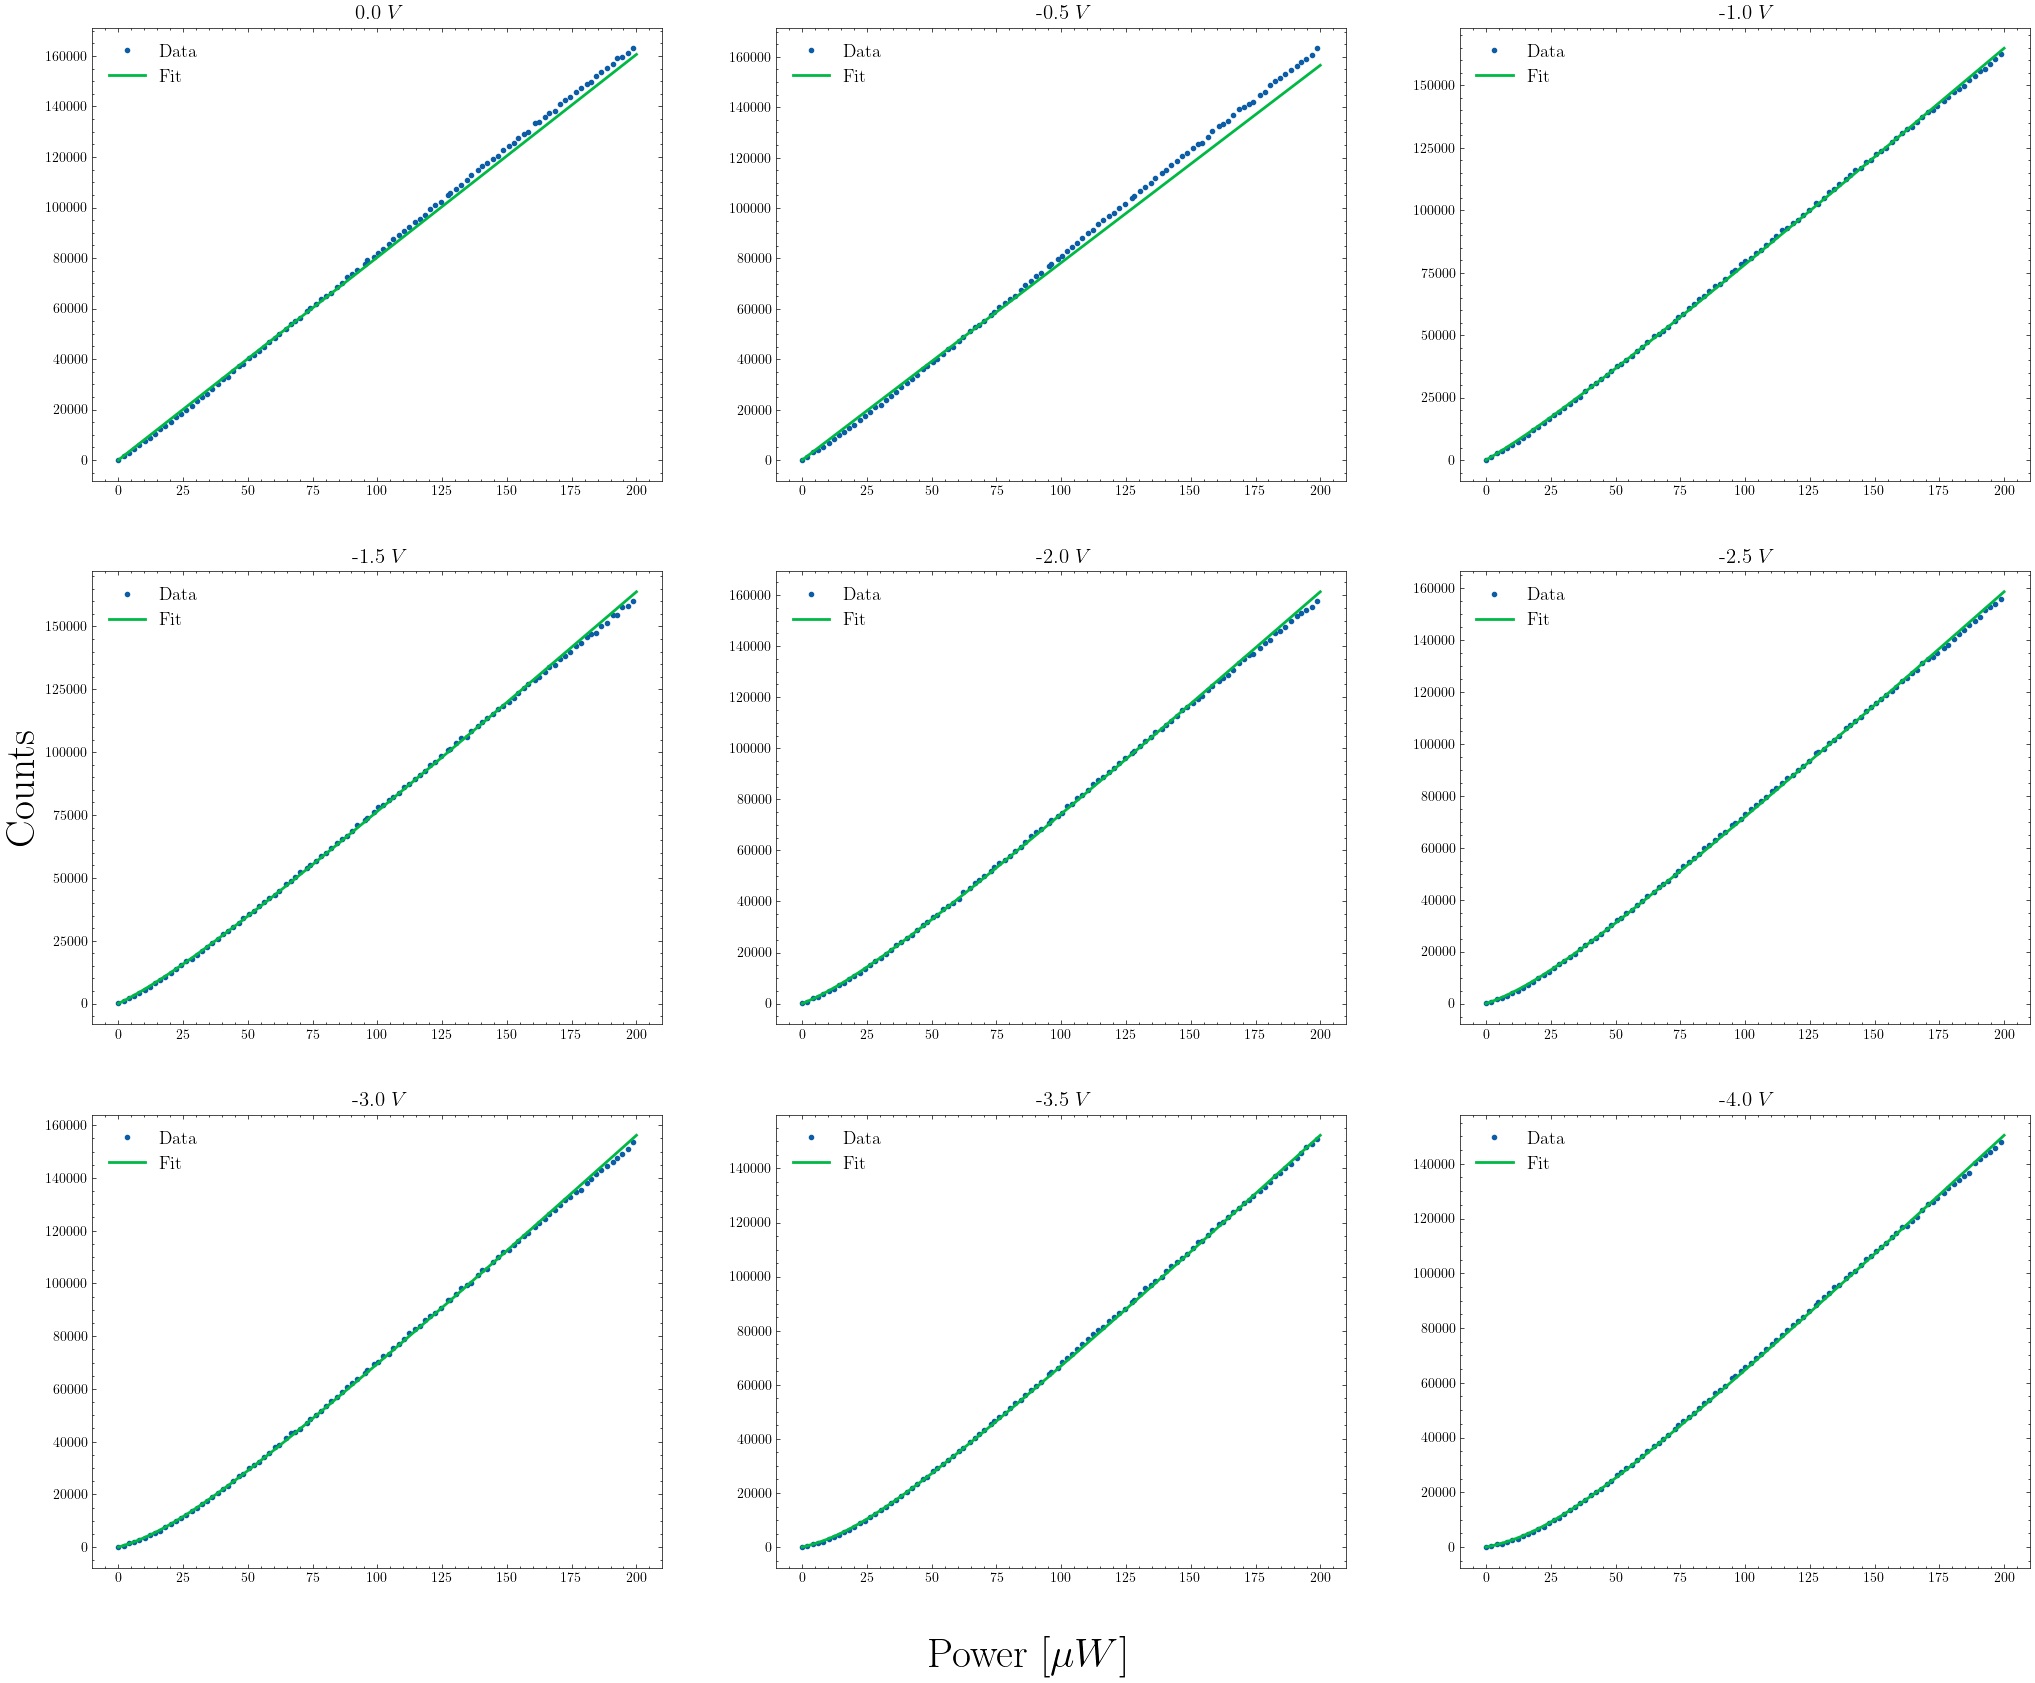

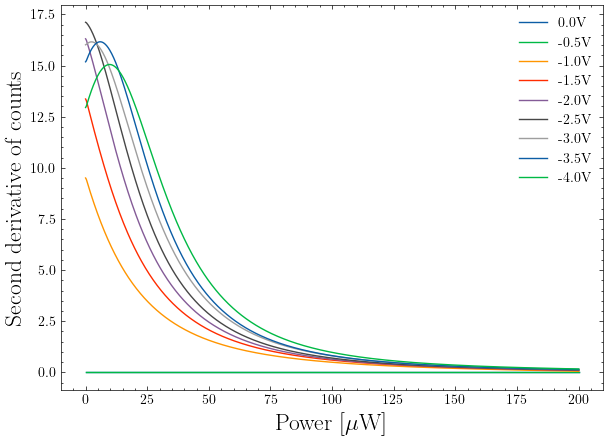

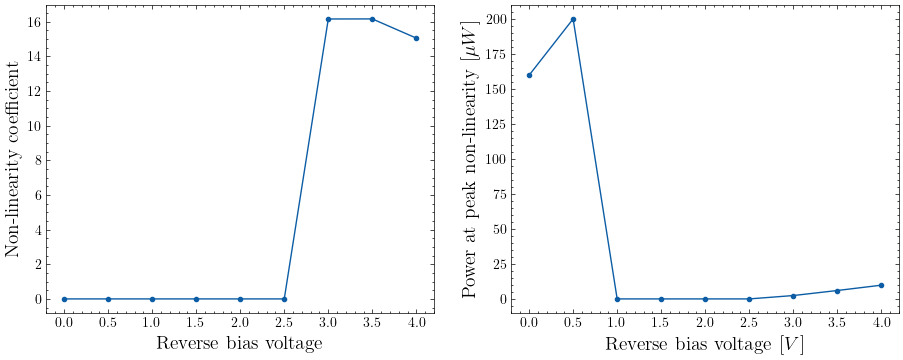

PLOTS FOR RESISTANCE 10,000,000
[0.36515820878360866, 877.099934962588]
Fit with resistance 10000000 and voltage 0.0 was not completely successful.
[0.11724340523582366, 871.1568214481852]
Fit with resistance 10000000 and voltage -0.5 was not completely successful.
[0.17654552125000747, 861.9554866183796]
Fit with resistance 10000000 and voltage -1.0 was not completely successful.
[0.08412490396826601, 842.5675537666766]
Fit with resistance 10000000 and voltage -1.5 was not completely successful.
[0.08635773245217677, 819.7805098860998]
Fit with resistance 10000000 and voltage -2.0 was not completely successful.
[0.08878790118458162, 794.6151831646806]
Fit with resistance 10000000 and voltage -2.5 was not completely successful.
[0.14002723181680032, 758.9038656140953]
Fit with resistance 10000000 and voltage -3.0 was not completely successful.
[0.13717894824490365, 723.7958507211663]
Fit with resistance 10000000 and voltage -3.5 was not completely successful.
[0.06455666842016856, 680.

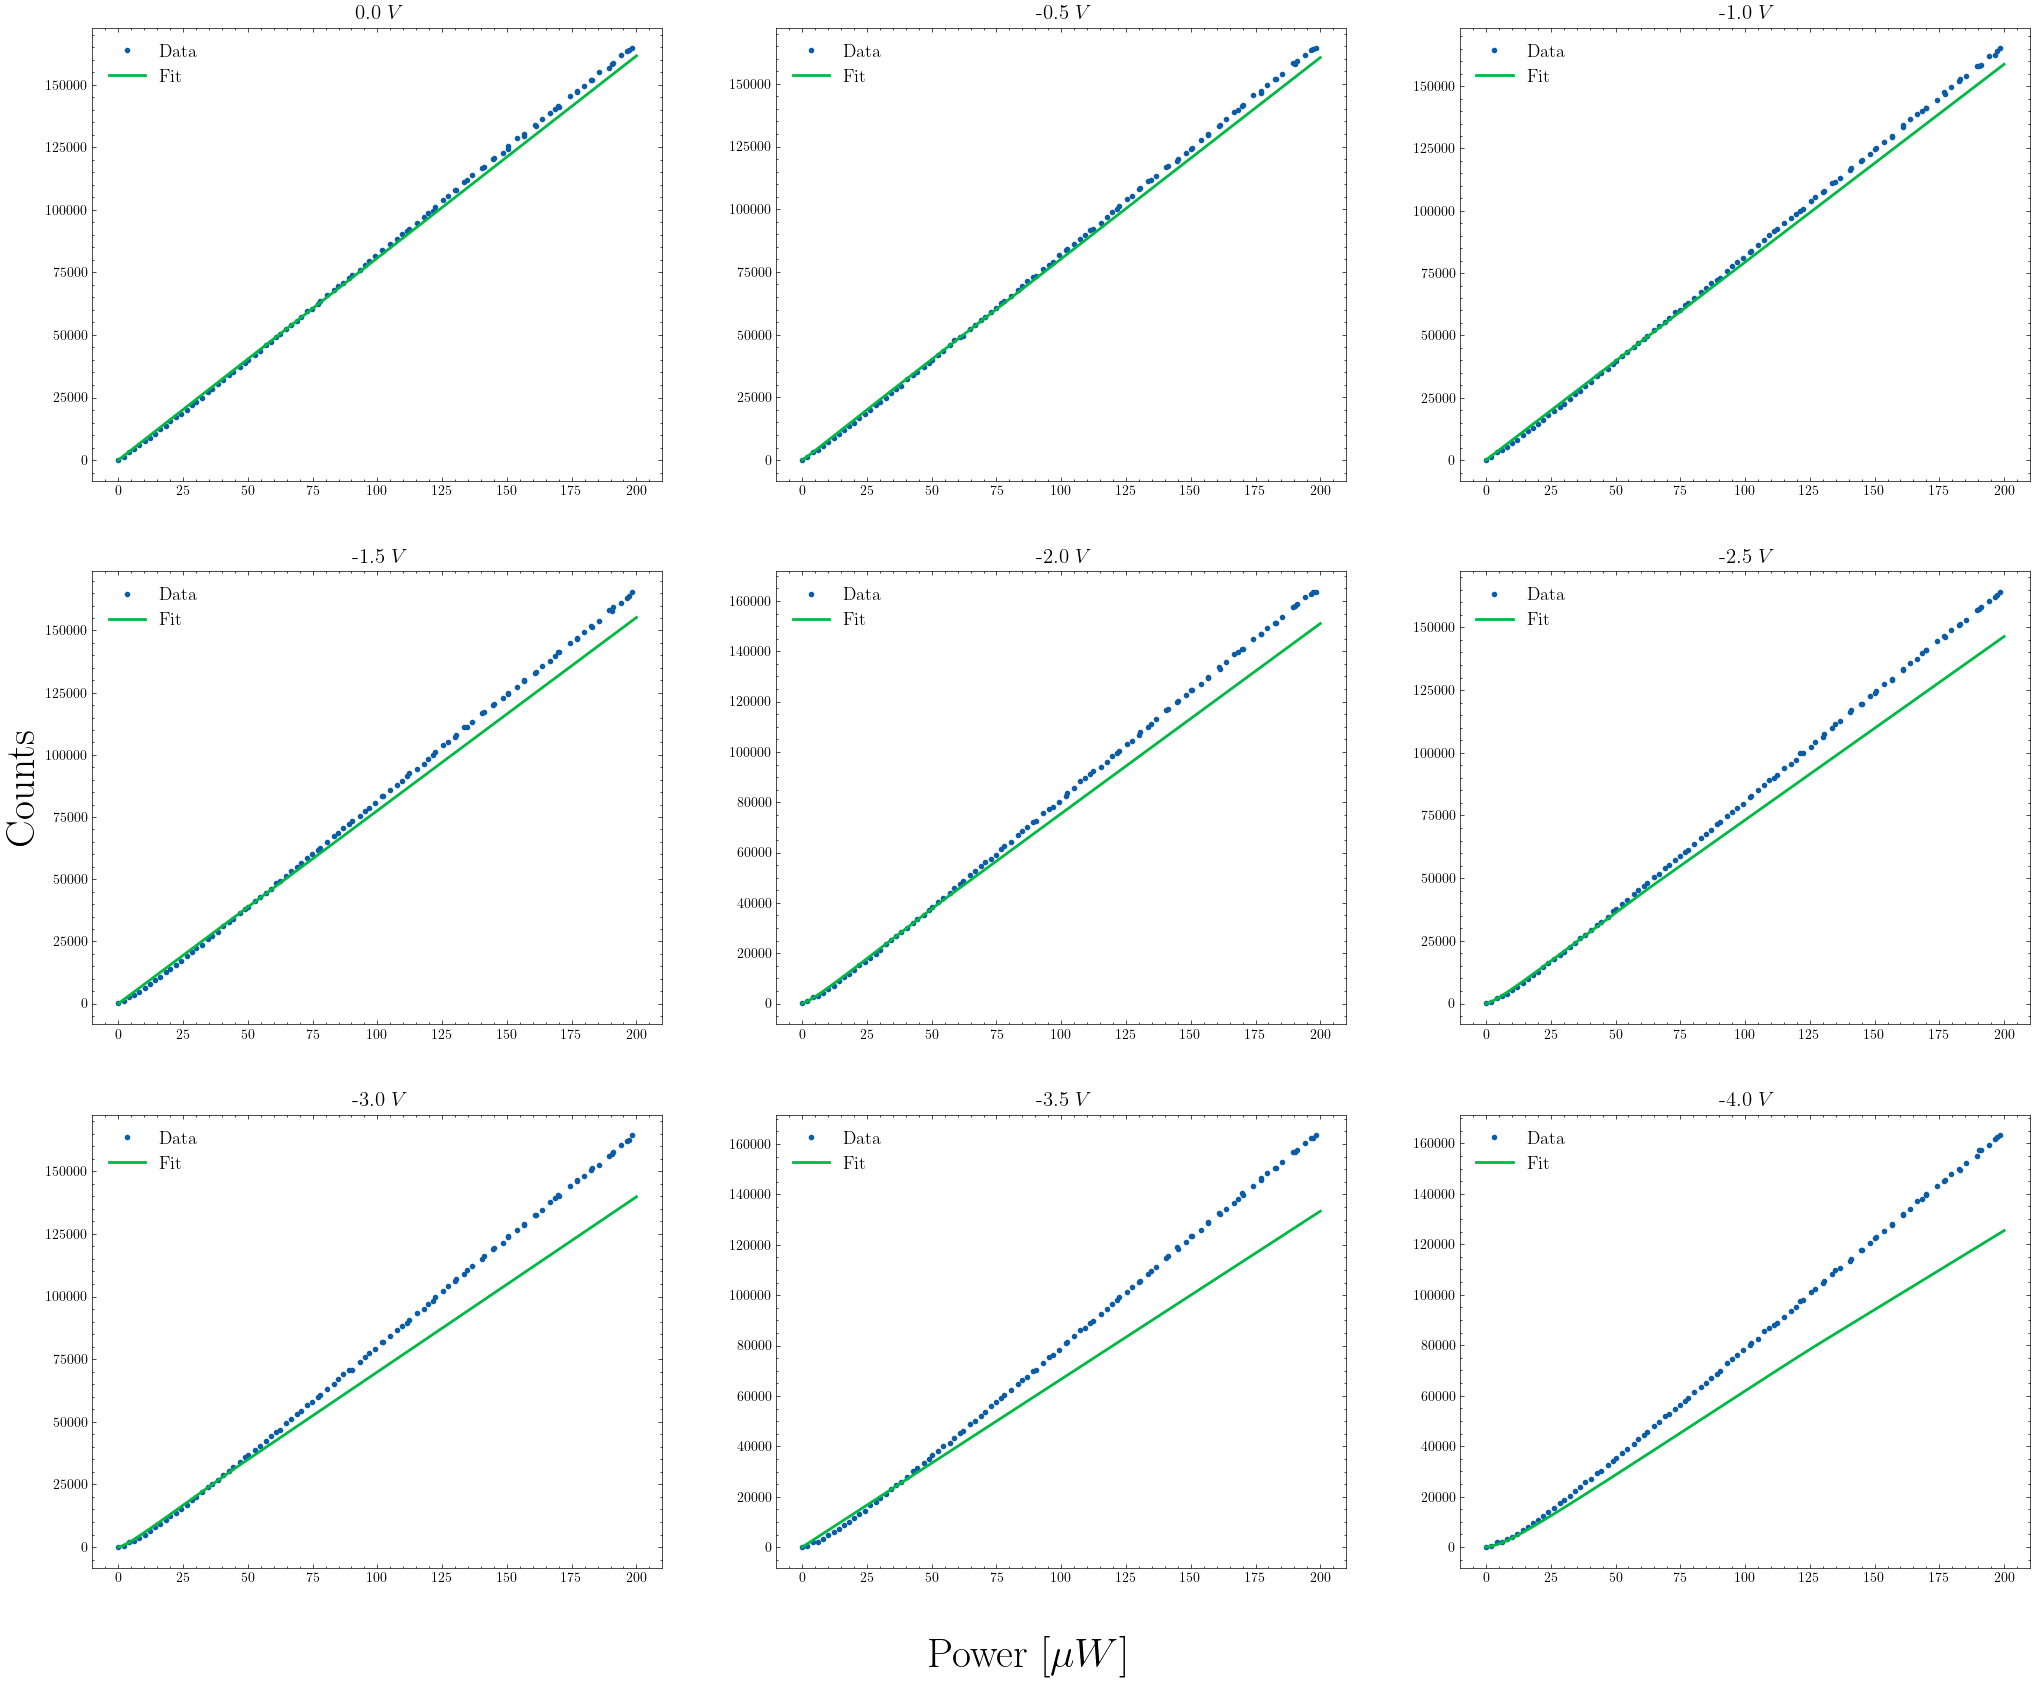

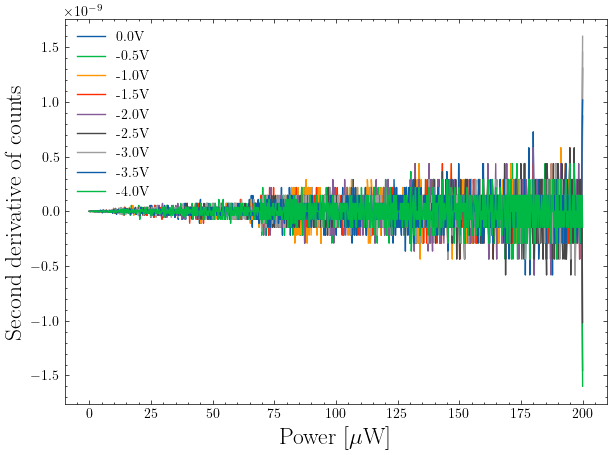

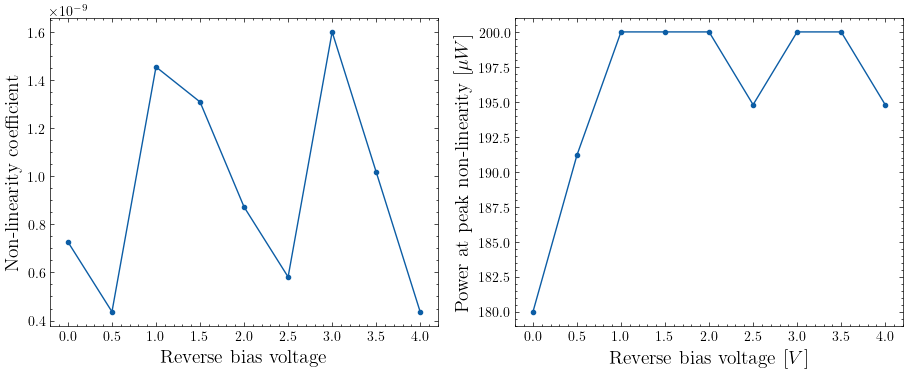

In [14]:
for idx in range(len(resistances)):
    max_deriv, max_nl_voltage = fit_and_plot_for_resistance(
        data_dict,
        voltagelist,
        resistances[idx],
        [0.1, 1000],
        bounds={"eta": [0, 1], "norm": [100, 5_000]},
        softloss=False,
        initial_guesses_feedback=True,
    )
    max_deriv_res.append(max_deriv)
    max_nl_voltage_res.append(max_nl_voltage)

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

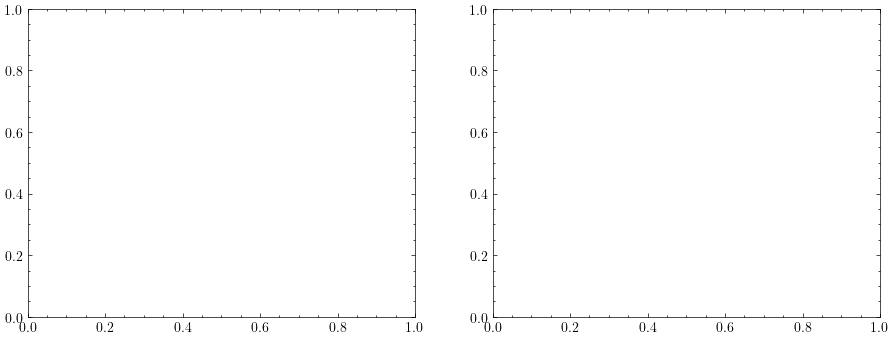

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(np.array(resistances[1:]) * 1e-6, max_deriv_res, ".-")
ax1.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax1.set_ylabel(r"Non-linearity coefficient", fontsize=14)
ax2.plot(np.array(resistances[1:]) * 1e-6, np.abs(max_nl_voltage_res), ".-")
ax2.set_xlabel(r"Resistance [$V$]", fontsize=14)
ax2.set_ylabel(r"Reverse voltage with max non-linearity", fontsize=14)

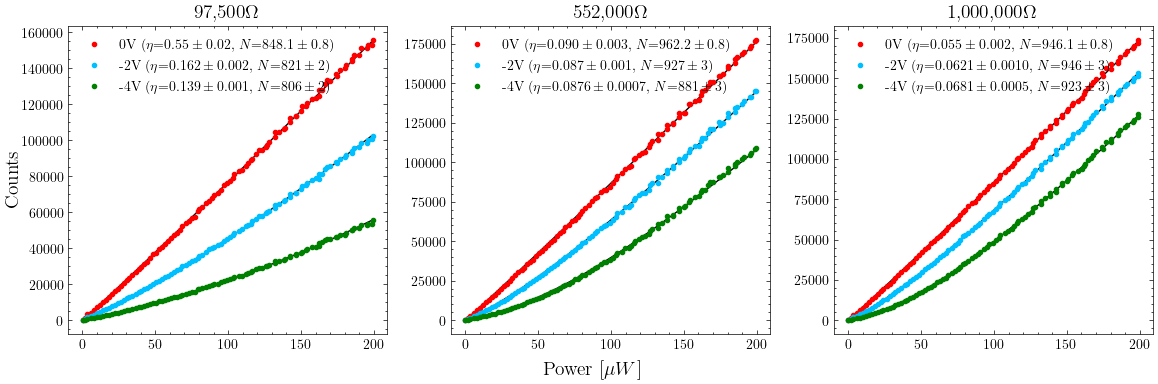

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "deepskyblue", "green"]
for i, res_idx in enumerate([1, 3, 6]):
    for j, voltage_idx in enumerate([0, 4, 8]):
        fk_fit = FKFit(
            data_dict[0]["M_power"],
            resistances[res_idx] * 1e-6,
            3.5e-3,
            2.99792458e5 / 321.5,
            0.3,
            298,
            voltagelist[voltage_idx],
        )
        fit_input = FitInput(
            data_dict[0]["M_power"],
            data_dict[resistances[res_idx]]["counts"][:, voltage_idx],
            np.sqrt(data_dict[resistances[res_idx]]["counts"][:, voltage_idx]),
            fk_fit.FK_fit_power_scaled,
            [0.1, 1000],
        )
        fit_result = perform_fit(
            fit_input, bounds={"eta": [0, 1], "norm": [500, 2_000]}
        )

        axs[i].plot(
            fit_input.xdata,
            fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
            color="black",
        )
        axs[i].plot(
            fit_input.xdata,
            fit_input.ydata,
            ".",
            label=rf"{voltagelist[voltage_idx]:.0f}V   ($\eta$={num_err_to_latex_str(fit_result.parameters[0], fit_result.parameter_errors[0])}, $N$={num_err_to_latex_str(fit_result.parameters[1], fit_result.parameter_errors[1])})",
            color=colors[j],
        )
    axs[i].set_title(f"{resistances[res_idx]:,}$\Omega$", fontsize=14)
    axs[i].legend()
fig.text(0.5, 0.01, r"Power [$\mu W$]", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Counts", va="center", rotation="vertical", fontsize=14)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


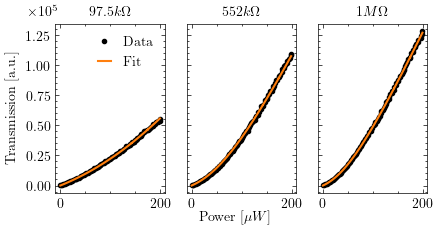

In [87]:
voltage_idx = -1
titles = [r"97.5$k\Omega$", r"552$k\Omega$", r"1$M\Omega$"]
fig, axs = plt.subplots(1, 3, figsize=(4.8, 2.2), sharey=True)
for i, res_idx in enumerate([1, 3, 6]):
    fk_fit = FKFit(
        data_dict[resistances[res_idx]],
        resistances[res_idx] * 1e-6,
        3.5e-3,
        2.99792458e5 / 321.5,
        0.3,
        298,
        voltagelist[voltage_idx],
    )
    fit_input = FitInput(
        data_dict[0]["M_power"],
        data_dict[resistances[res_idx]]["counts"][:, voltage_idx],
        np.sqrt(data_dict[resistances[res_idx]]["counts"][:, voltage_idx]),
        fk_fit.FK_fit_power_scaled,
        [0.1, 1000],
    )
    fit_result = perform_fit(
        fit_input, bounds={"eta": [0, 1], "norm": [500, 2_000]}
    )

    if i == 0:
        label1 = "Data"
        label2 = "Fit"
    else:
        label1 = ""
        label2 = ""
    
    axs[i].plot(
        fit_input.xdata,
        fit_input.ydata / 1e5,
        ".",
        color="black",
        label=label1,
    )

    axs[i].plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters) / 1e5,
        color="tab:orange",
        lw=1.5,
        label=label2,
    )

    axs[i].set_title(titles[i], fontsize=10)


    axs[i].legend(fontsize=10, frameon=False, handlelength=1.0)
fig.supxlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
fig.supylabel(r"Transmission [a.u.]", fontsize=10)
fig.text(0.07, 0.925, r"$\times 10^{5}$")
# savefig(NB_NAME, "nl_transmission_resistances", fig, svg=True)
plt.show()

/home/ali/Code/Master's project/data_analysis/utilities.py:144: RuntimeWarning: invalid value encountered in power
  beta1 = 1.1e5 * (Eg - Eph) * (2 * mu1) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:145: RuntimeWarning: invalid value encountered in power
  beta2 = 1.1e5 * (Eg - Eph) * (2 * mu2) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:158: RuntimeWarning: invalid value encountered in power
  FKa = (a1 + a2) * F ** (1 / 3) * 1e4 / n
/home/ali/Code/Master's project/data_analysis/utilities.py:226: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  alpha = fsolve(func, self.alphas[-1])[0]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with a

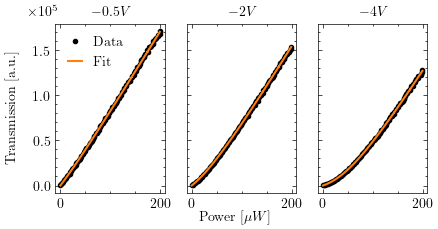

In [ ]:
titles = [r"$-0.5V$", r"$-2V$", r"$-4V$"]
fig, axs = plt.subplots(1, 3, figsize=(4.8, 2.2), sharey=True)
res_idx = 6
for i, voltage_idx in enumerate([1, 4, 8]):
    fk_fit = FKFit(
        data_dict[resistances[res_idx]]["M_power"],
        resistances[res_idx] * 1e-6,
        3.5e-3,
        2.99792458e5 / 321.5,
        0.3,
        298,
        voltagelist[voltage_idx],
    )
    fit_input = FitInput(
        data_dict[0]["M_power"],
        data_dict[resistances[res_idx]]["counts"][:, voltage_idx],
        np.sqrt(data_dict[resistances[res_idx]]["counts"][:, voltage_idx]),
        fk_fit.FK_fit_power_scaled,
        [0.1, 1000],
    )
    fit_result = perform_fit(
        fit_input, bounds={"eta": [0, 1], "norm": [500, 2_000]}
    )

    if i == 0:
        label1 = "Data"
        label2 = "Fit"
    else:
        label1 = ""
        label2 = ""
    
    axs[i].plot(
        fit_input.xdata,
        fit_input.ydata / 1e5,
        ".",
        color="black",
        label=label1,
    )

    axs[i].plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters) / 1e5,
        color="tab:orange",
        lw=1.5,
        label=label2,
    )

    axs[i].set_title(titles[i], fontsize=10)


    axs[i].legend(fontsize=10, frameon=False, handlelength=1.0)
fig.supxlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
fig.supylabel(r"Transmission [a.u.]", fontsize=10)
fig.text(0.07, 0.925, r"$\times 10^{5}$")
# savefig(NB_NAME, "nl_transmission_voltages", fig, svg=True)
plt.show()